In [1]:
#libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
# Pickle it for later use
import pickle
sns.set()

In [2]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# stop fuzzy charts
%config InlineBackend.figure_format = "retina"

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity ='all'

In [5]:
df_fertiliser =  pd.read_pickle("../data/df_fertiliser.pkl")  
#new variables
df_all =  pd.read_pickle("../data/df_all.pkl")  
#tweets
df_tweets= pd.read_csv("../data/farmtweets.csv")   #farm tweets

### Removing outliers

def is_outlier(s):
    lower_limit = s.mean() - (s.std() * 3)
    upper_limit = s.mean() + (s.std() * 3)
    return ~s.between(lower_limit, upper_limit)

df_all = df_all[~df_all.groupby('fertiliser_type')['fertiliser_price'].apply(is_outlier)]
#df_all.groupby('fertiliser_type')['fertiliser_price'].describe()

In [6]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1720 entries, 10080 to 12143
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1720 non-null   datetime64[ns]
 1   fertiliser_type       1720 non-null   category      
 2   fertiliser_price      1720 non-null   float64       
 3   month_year            1720 non-null   period[M]     
 4   month                 1720 non-null   category      
 5   year                  1720 non-null   category      
 6   phosphate_price       1720 non-null   float64       
 7   urea_price            1720 non-null   float64       
 8   milk_price            1720 non-null   float64       
 9   gas_price             1720 non-null   float64       
 10  potassium_price       1720 non-null   float64       
 11  consumer_price_index  1720 non-null   float64       
dtypes: category(3), datetime64[ns](1), float64(7), period[M](1)
memory usag

In [7]:
df_all.shape

(1720, 12)

In [8]:
#df_all

In [9]:
#df_urea= df_all[df_all.fertiliser_type == "Calcium Ammonium Nitrate (27.5% N)"]

In [10]:
#keep date, fertiliser_type, month_year, month, year
X_new= df_all.drop(['fertiliser_price', 'month_year'], axis=1) # feature matrix 
feature_name = X_new.columns
y_new = df_all['fertiliser_price']
class_labels = np.unique(y_new)

In [11]:
X_new.head()

,date,fertiliser_type,month,year,phosphate_price,urea_price,milk_price,gas_price,potassium_price,consumer_price_index
10080,2015-01-01,Calcium Ammonium Nitrate (27.5% N),1,2015,103.06,263.04,0.345,2.56,241.05,-0.234183
10081,2015-01-01,Urea (46% N),1,2015,103.06,263.04,0.345,2.56,241.05,-0.234183
10083,2015-01-01,Muriate of Potash (50% K),1,2015,103.06,263.04,0.345,2.56,241.05,-0.234183
10084,2015-01-01,Compound 0-10-20,1,2015,103.06,263.04,0.345,2.56,241.05,-0.234183
10085,2015-01-01,Compound 0-7-30,1,2015,103.06,263.04,0.345,2.56,241.05,-0.234183


### Encoding the data

In [12]:
import category_encoders as ce

# columns to encode 
encoder = ce.OrdinalEncoder(cols=[ 
                                  'fertiliser_type',
                                  'month', 
                                  'year', 'date'])

X_new = encoder.fit_transform(X_new)
#X_new
#X_new. iloc[:, [0,1,2, 3, 4]]
X_new.shape

(1720, 10)

### One hot encoding 

In [13]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import set_config

#columns to one hot encode
ct = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(categories='auto'), [0, 1, 2, 3, 4])],   # The column numbers to be transformed (here is [0] but can be [0, 1, 3])
    remainder='passthrough'                                         # Leave the rest of the columns untouched
)

set_config(display='diagram')

X_new =ct.fit_transform(X_new)


###  Split data into test and train

In [14]:
from sklearn.model_selection import train_test_split # Import train_test_split function [2]
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.33, random_state=0) # 67% training and 33% test // found out by 1 - test_size = 1 - 0.33 = 0.67 -> 67%
X_train.shape, X_test.shape

((1152, 216), (568, 216))

## Standard Scaler
had to use with mean false

In [15]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler(with_mean=False)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Linear regression

In [16]:
# Training the Multiple Linear Regression model on the Training set
#This is the same code we used in Simple Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

regr = LinearRegression()
regr.fit(X_train, y_train)

#x_trans_ = regr.fit(X_train, y_train)

LinearRegression()

#### Predictions

In [17]:
#y_test
#X_test
y_pred = regr.predict(X_test)

In [18]:
df=pd.DataFrame({'Input':X_test, 'Actual':y_test, 'Predicted':y_pred, 'Difference': (y_test - y_pred)})

df.head()

,Input,Actual,Predicted,Difference
10638,"(0, 23)\t9.126774707991006\n (0, 91)\t4.500...",460.0,444.362887,15.637113
10229,"(0, 6)\t8.293351786577078\n (0, 90)\t4.3981...",413.0,423.124050,-10.124050
10855,"(0, 32)\t11.358163320526257\n (0, 92)\t4.43...",374.0,370.784875,3.215125
10378,"(0, 12)\t9.849392180017482\n (0, 95)\t4.611...",422.0,411.588938,10.411062
11990,"(0, 79)\t10.282845588325983\n (0, 98)\t4.53...",405.0,414.746499,-9.746499


#### Evaluation of Linear Regression model

In [19]:
#We calculate the precision of the model or r^2
print('The precision of the training data: %.2f '% regr.score(X_train, y_train))
print('The precision of the test data: %.2f'% regr.score(X_test, y_test))
#0.43271583296060845
#added inflation - 0.4354100616894637
#one hot encoding - 0.8815790041207024

The precision of the training data: 0.90 
The precision of the test data: 0.89


In [20]:
import math 

# The mean absolute error - doesn't say if it is too high or low
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,y_pred))

# The mean squared error
model_mse = mean_squared_error(y_test,y_pred)

print("Mean squared error: %.2f" % model_mse)

model_rmse = math.sqrt(model_mse)
# The root mean squared error
print("Root mean squared error: %.2f" % model_rmse)

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test,y_pred))

Mean absolute error: 14.03
Mean squared error: 667.93
Root mean squared error: 25.84
Coefficient of determination: 0.89


In [21]:
print("Coefficients: \n", regr.coef_)

Coefficients: 
 [ 2.95789939e-01  4.22905006e-01  9.67285264e-01  1.11360788e+00
  1.07640425e+00  1.03370891e+00  1.10898545e+00  6.52507289e-01
  8.00809817e-01  8.13365903e-01  6.92899223e-01  6.68835567e-01
  8.94865708e-01  8.63494041e-01  1.66002936e+00  6.31213210e-01
  6.54050800e-01 -3.64911075e-02 -7.45412115e-01 -1.64306850e-01
 -9.29205364e-01 -1.31431044e+00 -1.25363045e+00 -2.07496469e+00
 -1.72086938e+00 -2.16494319e+00 -6.53959098e-01 -6.05385436e-01
 -5.01566862e-01 -6.54555945e-01 -1.00105226e+00 -1.22480956e+00
 -1.10104468e+00 -1.27186847e+00 -1.54054242e+00 -1.11735339e+00
 -1.24672788e+00 -9.34694751e-01 -6.70158736e-01 -3.53614566e-01
 -8.54285890e-01 -9.42562797e-01 -7.28235506e-01 -7.14225234e-01
 -6.58515287e-01 -6.81481480e-01 -7.94600038e-01 -1.51096761e+00
 -3.70247236e-01  2.36375601e-01  6.87016582e-01  1.37992660e-01
 -1.88471471e-01 -3.17280455e-02 -6.71501798e-02  2.00694453e-01
 -4.56881729e-02 -1.26694940e-01 -2.17656800e-01 -5.96125056e-01
 -9.91532

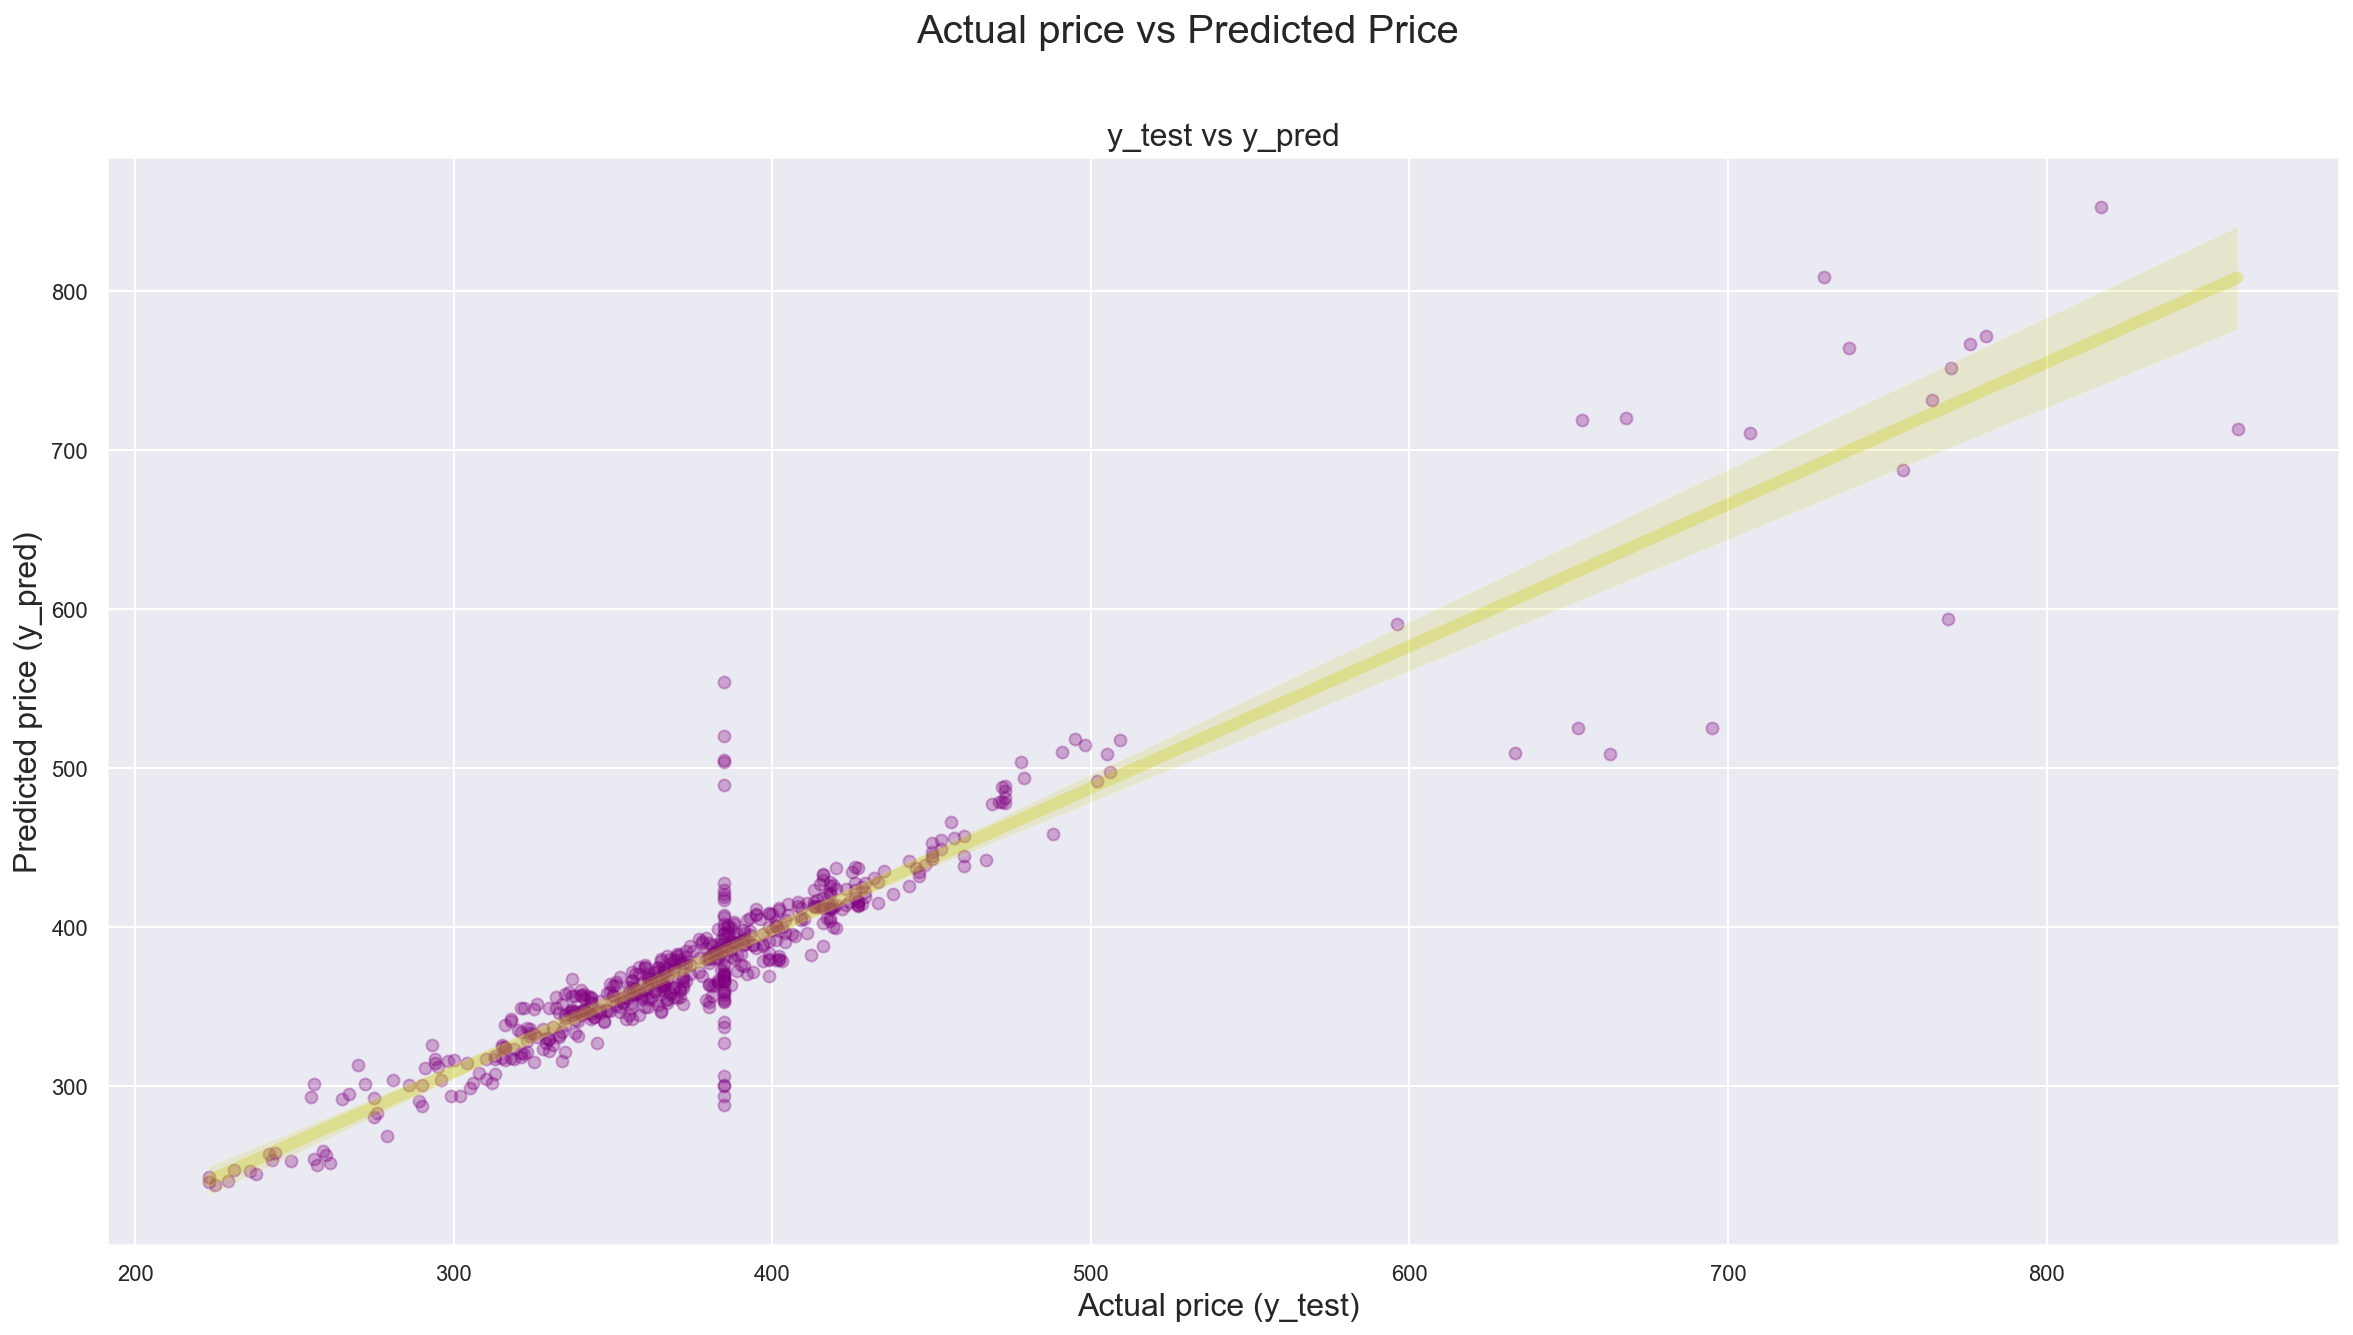

In [22]:
#set to seaborn
#sns.set_theme(style='white')
#palette
sns.set_palette('rainbow');
plt.figure(figsize=(20, 10));  
#fig = plt.figure()
sns.regplot(y_test,y_pred, scatter_kws = {'color': 'purple', 'alpha': 0.3}, line_kws = {'color': '#CCCC00', 'alpha': 0.3, 'lw':6})
plt.suptitle('Actual price vs Predicted Price', fontsize=20); 
plt.title('y_test vs y_pred'  , fontsize=16);   
  
plt.xlabel('Actual price (y_test) ', fontsize=16);                       
plt.ylabel('Predicted price (y_pred)', fontsize=16);  

In [23]:
coef = pd.Series(regr.coef_)
coef

0       0.295790
1       0.422905
2       0.967285
3       1.113608
4       1.076404
         ...    
211    12.292392
212     4.093058
213     4.561890
214     7.209403
215     7.624501
Length: 216, dtype: float64

## Lasso

In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso

# function to get cross validation scores
def get_cv_scores(model):
    scores = cross_val_score(model,
                             X_train,
                             y_train,
                             cv=5,
                             scoring='r2')
    
    print('CV Mean: ', np.mean(scores))
    print('STD: ', np.std(scores))
    print('\n')
    

In [25]:
# Train model with default alpha=1
lasso = Lasso(alpha=1).fit(X_train, y_train)
# get cross val scores
#get_cv_scores(lasso)

print('The precision of the training data: %.2f ', lasso.score(X_train, y_train))
print('The precision of the test data: %.2f'% lasso.score(X_test, y_test))
print('\n')
get_cv_scores(lasso)
#inflation - 0.429963165407963
#onehot encoding - 0.8627252790023363



The precision of the training data: %.2f  0.8934153979426396
The precision of the test data: 0.88


CV Mean:  0.879469571315358
STD:  0.03457953699904418




#### Predictions for Lasso

In [26]:
y_pred = lasso.predict(X_test)

In [27]:
df=pd.DataFrame({'Input':X_test, 'Actual':y_test, 'Predicted':y_pred})
df.head()

,Input,Actual,Predicted
10638,"(0, 23)\t9.126774707991006\n (0, 91)\t4.500...",460.0,447.770450
10229,"(0, 6)\t8.293351786577078\n (0, 90)\t4.3981...",413.0,418.510961
10855,"(0, 32)\t11.358163320526257\n (0, 92)\t4.43...",374.0,373.280960
10378,"(0, 12)\t9.849392180017482\n (0, 95)\t4.611...",422.0,400.735842
11990,"(0, 79)\t10.282845588325983\n (0, 98)\t4.53...",405.0,416.358507


In [28]:
import math 

# The mean absolute error - doesn't say if it is too high or low
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,y_pred))

# The mean squared error
model_mse = mean_squared_error(y_test,y_pred)

print("Mean squared error: %.2f" % model_mse)

model_rmse = math.sqrt(model_mse)
# The root mean squared error
print("Root mean squared error: %.2f" % model_rmse)

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test,y_pred))

Mean absolute error: 15.79
Mean squared error: 723.00
Root mean squared error: 26.89
Coefficient of determination: 0.88


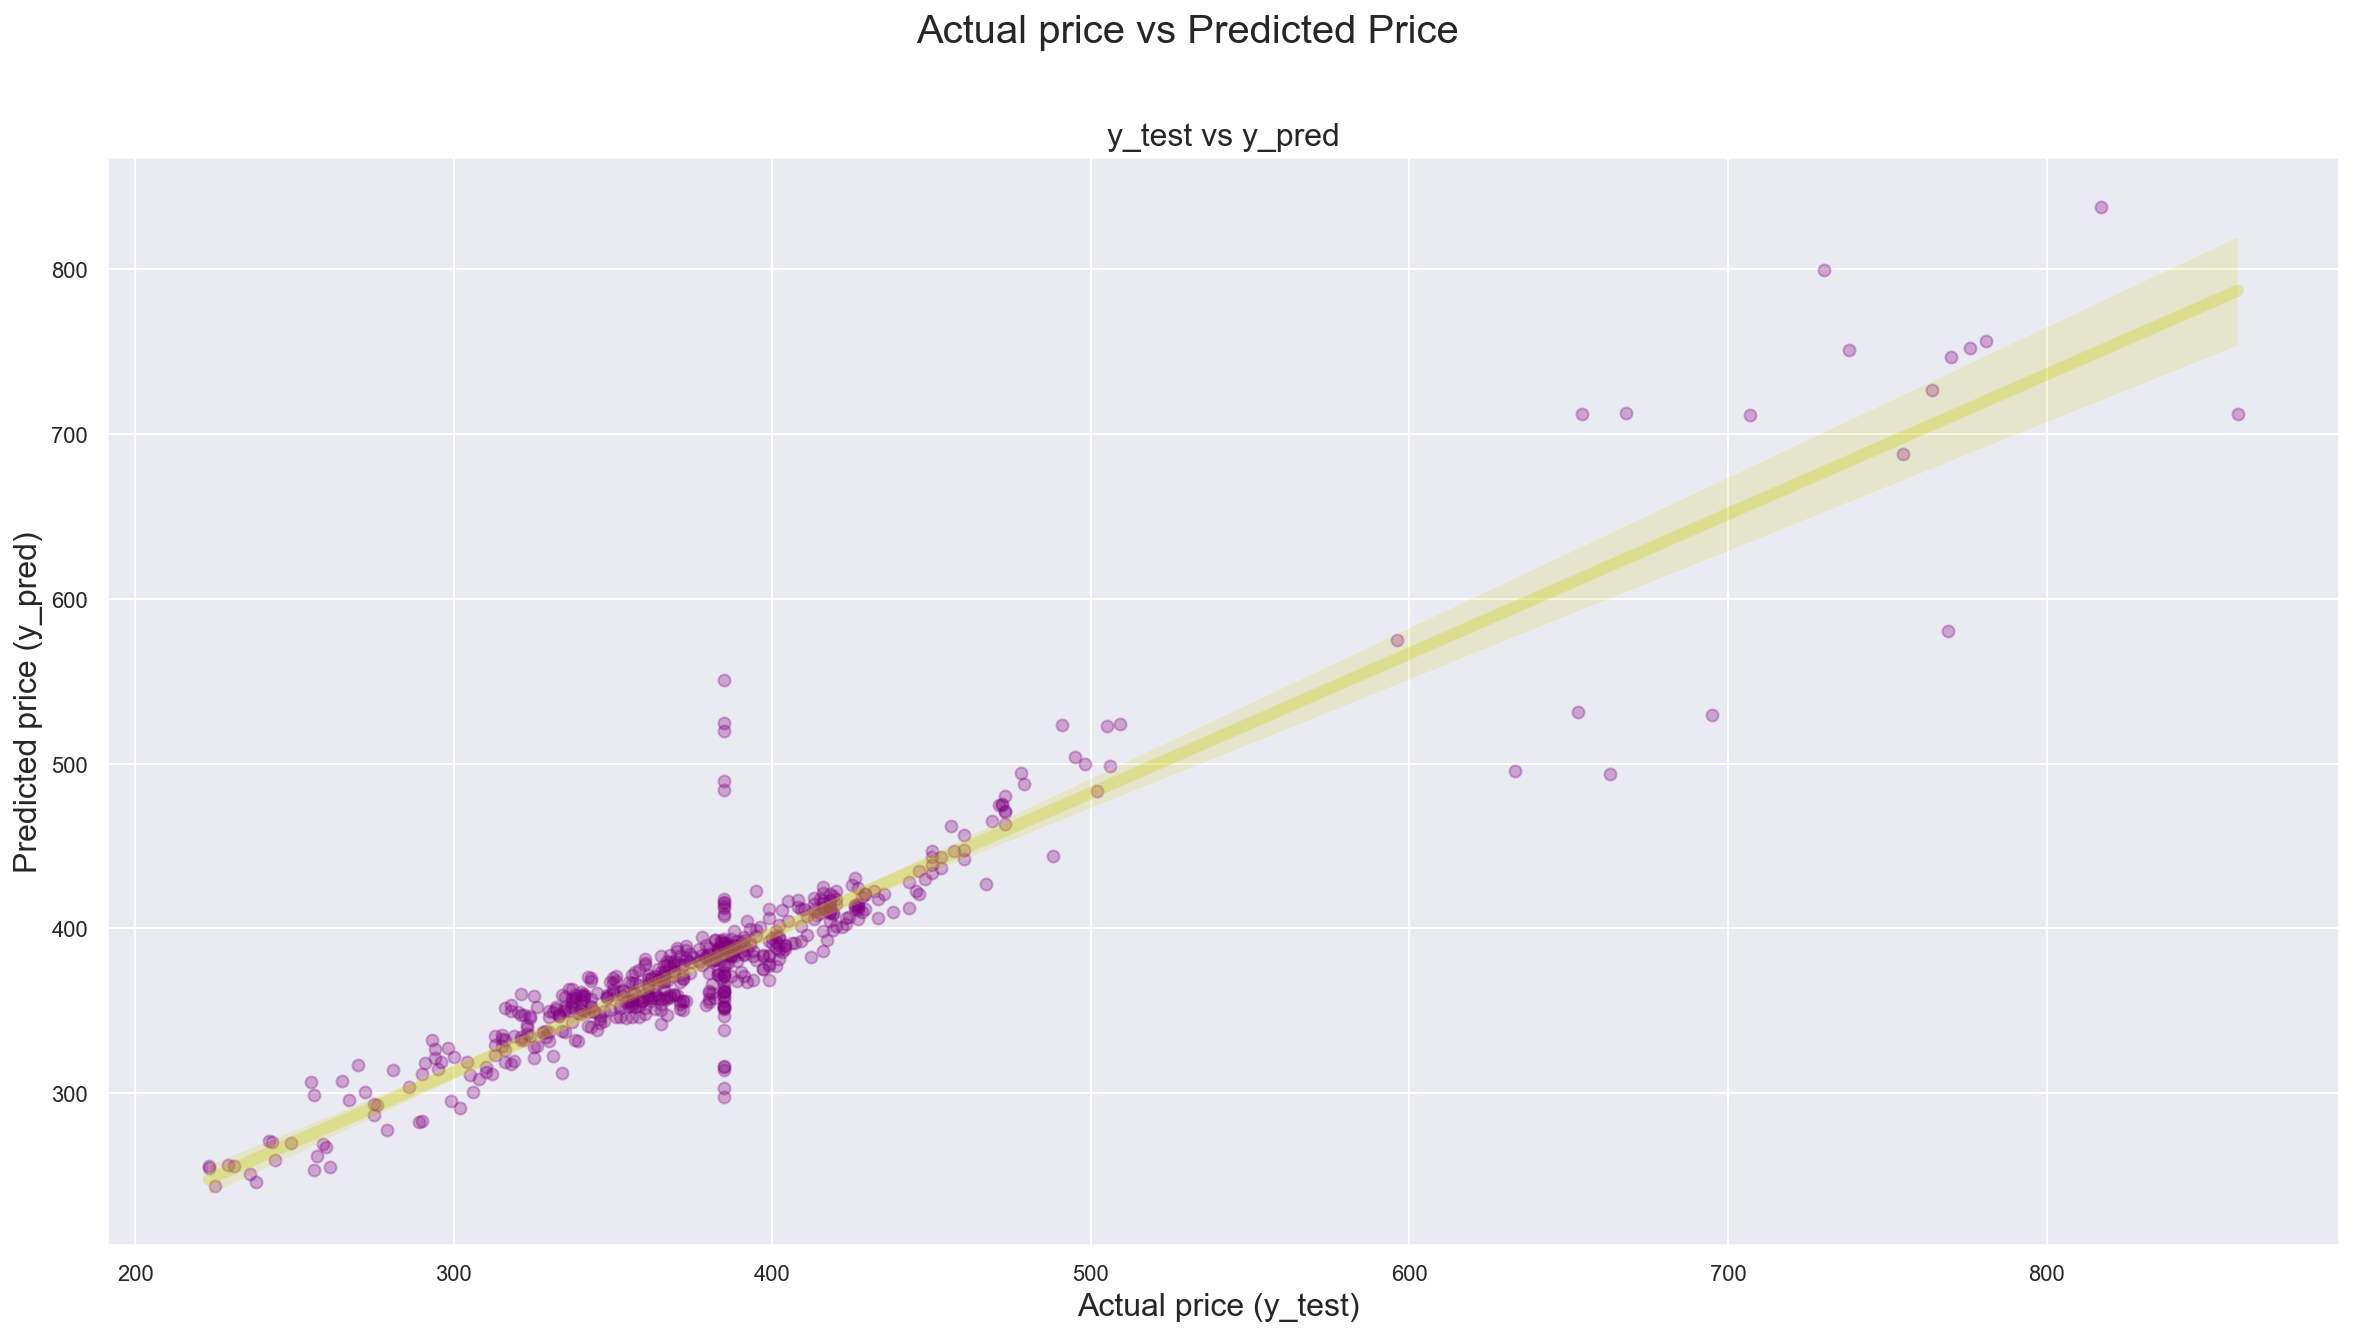

In [29]:
#set to seaborn
#sns.set_theme(style='white')
#palette
sns.set_palette('rainbow');
plt.figure(figsize=(20, 10));  
#fig = plt.figure()
sns.regplot(y_test,y_pred, scatter_kws = {'color': 'purple', 'alpha': 0.3}, line_kws = {'color': '#CCCC00', 'alpha': 0.3, 'lw':6})
plt.suptitle('Actual price vs Predicted Price', fontsize=20); 
plt.title('y_test vs y_pred'  , fontsize=16);   
  
plt.xlabel('Actual price (y_test) ', fontsize=16);                       
plt.ylabel('Predicted price (y_pred)', fontsize=16);  

## Ridge

In [30]:
from sklearn.linear_model import Ridge
# Train model with default alpha=1
ridge = Ridge(alpha=1).fit(X_train, y_train)
# get cross val scores
get_cv_scores(ridge)
print('The precision of the training data: %.2f '% ridge.score(X_train, y_train))
print('The precision of the test data: %.2f'% ridge.score(X_test, y_test))
#onehot encoding - 0.881578260923781

CV Mean:  0.8833846013525994
STD:  0.03442173142466732


The precision of the training data: 0.90 
The precision of the test data: 0.89


In [31]:
y_pred = ridge.predict(X_test)

In [32]:
df=pd.DataFrame({'Input':X_test, 'Actual':y_test, 'Predicted':y_pred})
df.head()

,Input,Actual,Predicted
10638,"(0, 23)\t9.126774707991006\n (0, 91)\t4.500...",460.0,444.394323
10229,"(0, 6)\t8.293351786577078\n (0, 90)\t4.3981...",413.0,423.367395
10855,"(0, 32)\t11.358163320526257\n (0, 92)\t4.43...",374.0,370.875852
10378,"(0, 12)\t9.849392180017482\n (0, 95)\t4.611...",422.0,411.371777
11990,"(0, 79)\t10.282845588325983\n (0, 98)\t4.53...",405.0,414.779748


In [33]:
import math 

# The mean absolute error - doesn't say if it is too high or low
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,y_pred))

# The mean squared error
model_mse = mean_squared_error(y_test,y_pred)

print("Mean squared error: %.2f" % model_mse)

model_rmse = math.sqrt(model_mse)
# The root mean squared error
print("Root mean squared error: %.2f" % model_rmse)

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test,y_pred))

Mean absolute error: 14.01
Mean squared error: 667.98
Root mean squared error: 25.85
Coefficient of determination: 0.89


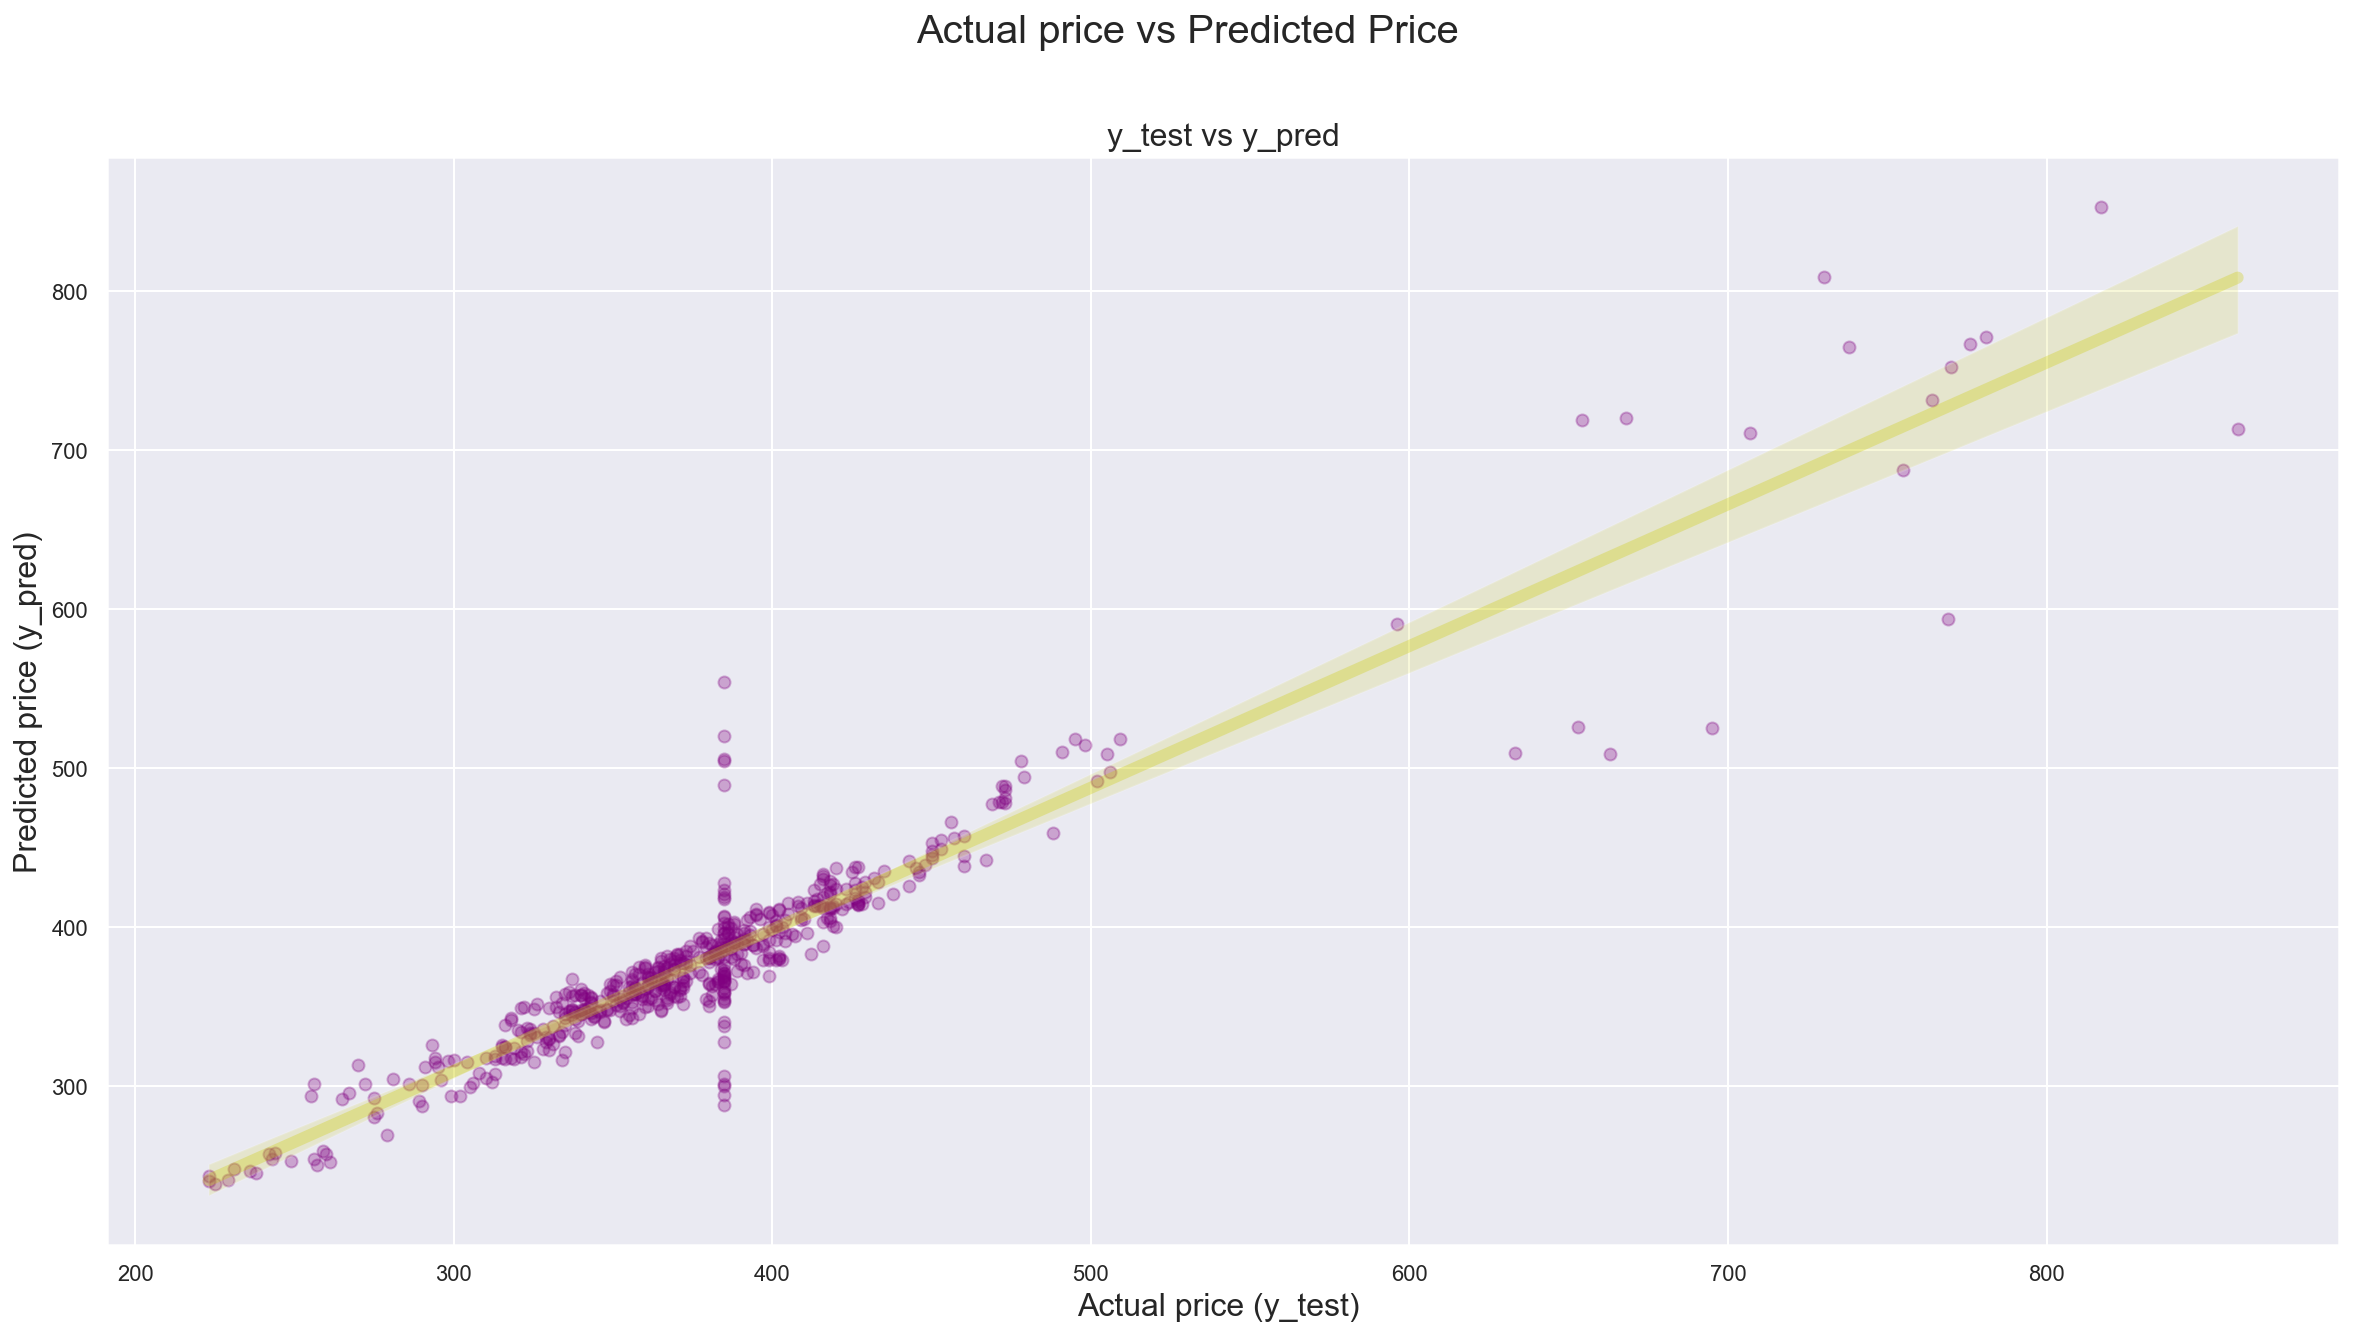

In [34]:
#set to seaborn
#sns.set_theme(style='white')
#palette
sns.set_palette('rainbow');
plt.figure(figsize=(20, 10));  
#fig = plt.figure()
sns.regplot(y_test,y_pred, scatter_kws = {'color': 'purple', 'alpha': 0.3}, line_kws = {'color': '#CCCC00', 'alpha': 0.3, 'lw':6})
plt.suptitle('Actual price vs Predicted Price', fontsize=20); 
plt.title('y_test vs y_pred'  , fontsize=16);   
  
plt.xlabel('Actual price (y_test) ', fontsize=16);                       
plt.ylabel('Predicted price (y_pred)', fontsize=16);  

### ElasticNet

In [35]:
from sklearn.linear_model import ElasticNet
# Train model with default alpha=1 and l1_ratio=0.5
elastic_net = ElasticNet(alpha=1, l1_ratio=0.5).fit(X_train, y_train)
# get cross val scores
get_cv_scores(elastic_net)

print('The precision of the training data: %.2f '% elastic_net.score(X_train, y_train))
print('The precision of the test data: %.2f'% elastic_net.score(X_test, y_test))
# onehot encoding 0.8095062920374447

CV Mean:  0.8431788928436432
STD:  0.029331789052502003


The precision of the training data: 0.86 
The precision of the test data: 0.85


In [36]:
y_pred = elastic_net.predict(X_test)

In [37]:
df=pd.DataFrame({'Input':X_test, 'Actual':y_test, 'Predicted':y_pred})
df.head()

,Input,Actual,Predicted
10638,"(0, 23)\t9.126774707991006\n (0, 91)\t4.500...",460.0,418.968928
10229,"(0, 6)\t8.293351786577078\n (0, 90)\t4.3981...",413.0,413.019945
10855,"(0, 32)\t11.358163320526257\n (0, 92)\t4.43...",374.0,366.731764
10378,"(0, 12)\t9.849392180017482\n (0, 95)\t4.611...",422.0,403.162528
11990,"(0, 79)\t10.282845588325983\n (0, 98)\t4.53...",405.0,414.709286


In [38]:
import math 

# The mean absolute error - doesn't say if it is too high or low
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,y_pred))

# The mean squared error
model_mse = mean_squared_error(y_test,y_pred)

print("Mean squared error: %.2f" % model_mse)

model_rmse = math.sqrt(model_mse)
# The root mean squared error
print("Root mean squared error: %.2f" % model_rmse)

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test,y_pred))

Mean absolute error: 19.38
Mean squared error: 950.03
Root mean squared error: 30.82
Coefficient of determination: 0.85


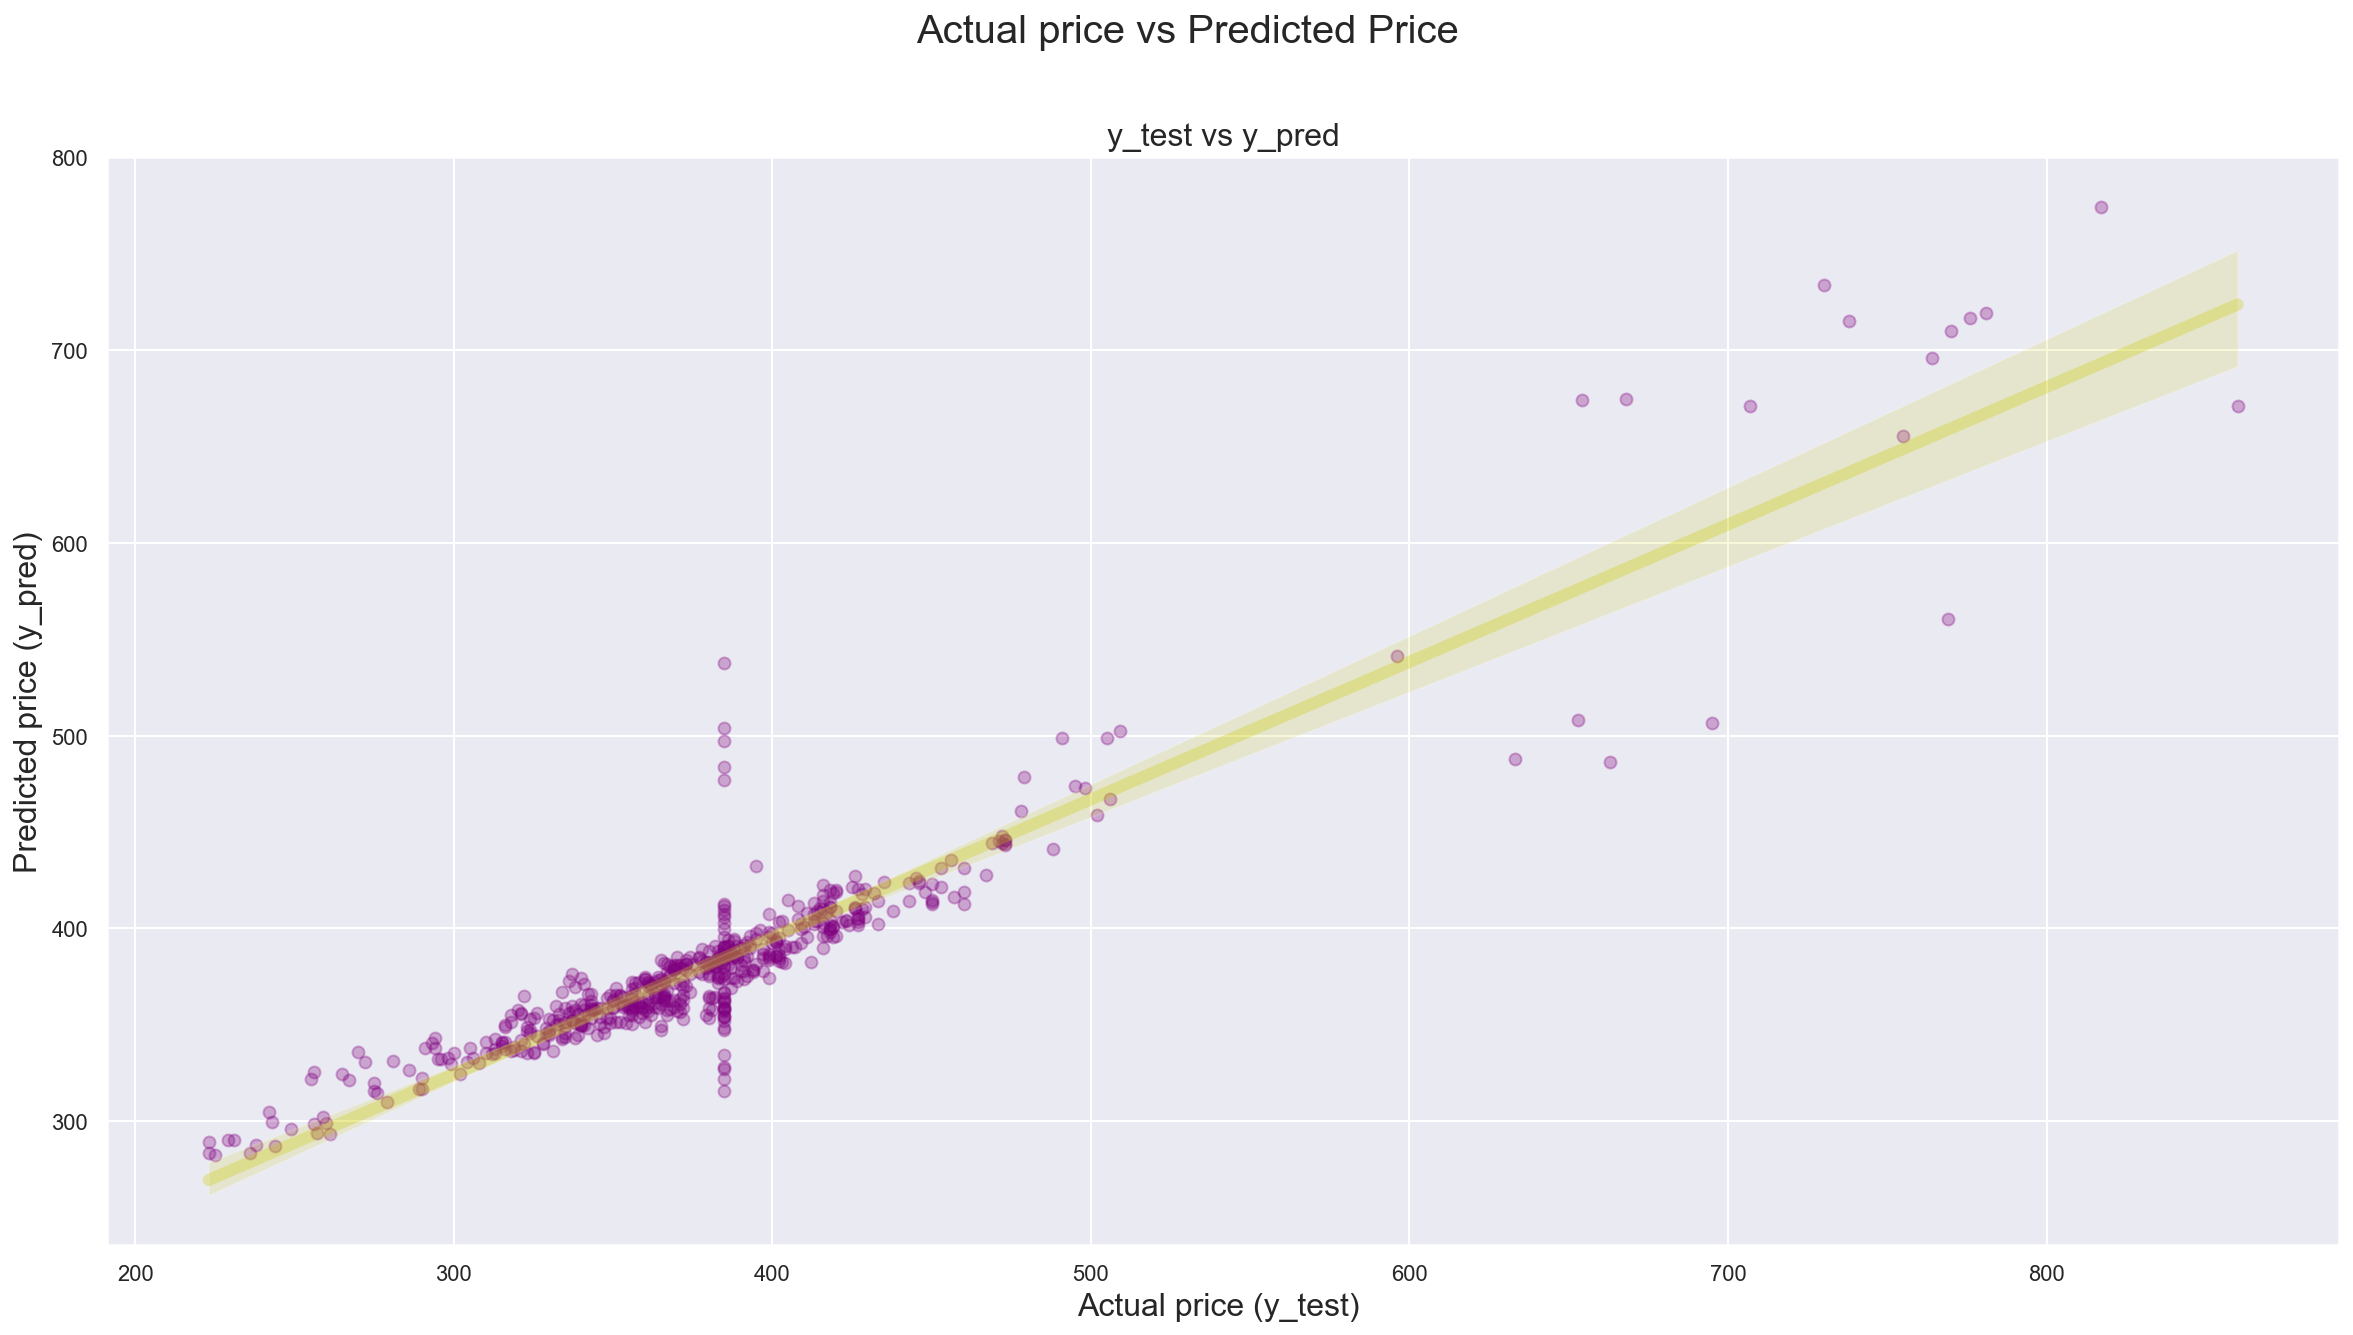

In [39]:
#set to seaborn
#sns.set_theme(style='white')
#palette
sns.set_palette('rainbow');
plt.figure(figsize=(20, 10));  
#fig = plt.figure()
sns.regplot(y_test,y_pred, scatter_kws = {'color': 'purple', 'alpha': 0.3}, line_kws = {'color': '#CCCC00', 'alpha': 0.3, 'lw':6})
plt.suptitle('Actual price vs Predicted Price', fontsize=20); 
plt.title('y_test vs y_pred'  , fontsize=16);   
  
plt.xlabel('Actual price (y_test) ', fontsize=16);                       
plt.ylabel('Predicted price (y_pred)', fontsize=16);  

## Grid search

Tuning hyperparameters for the ML algorithms

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [41]:
#ElasticNet().get_params().keys()

In [42]:
#LinearRegression().get_params().keys()

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# create a dictionary for the models and the parameters
model_params = {
    'LinearRegression': {
        'model': LinearRegression(),   # Linear regression
        'params' : {
            "fit_intercept": [True, False],
          #  "normalize": [0,1],
          #  "positive": [True, False]
            
        }
    },
      'Lasso': {
        'model': Lasso(),   # Lasso 
        'params' : {
            "alpha": [0,10,50,100],
            "fit_intercept": [True, False],
            "normalize": [0,1],
            "positive": [True, False]
            
        }
    },
     'Ridge': {
        'model': Ridge(),   # Ridge 
        'params' : {
            "alpha": [0,10,50,100],
            "fit_intercept": [True, False],
            "normalize": [0,1],
            "positive": [True, False],
            "solver":['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
            
        }
    },
    'Elastic Net': {
        'model': ElasticNet(),   # ElasticNet 
        'params' : {
            "alpha": [0,10,50,100],
            "fit_intercept": [True, False],
            "normalize": [0,1],
            "positive": [True, False]
            
        }
    }
}

In [44]:
#create a dataframe
scores = []


for model_name, mp in model_params.items():
    # create classifier with model and parameters
    clf =  GridSearchCV(mp['model'], mp['params'], cv=10, return_train_score=False)
    #fit to the model
    clf.fit(X_train,y_train)
    # add score into the dataset
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'results': clf.cv_results_
    })
    
df_grid_search = pd.DataFrame(scores,columns=['model', 'best_score', 'best_params','results'])
#stop cutting off text in column
pd.set_option('display.max_colwidth', -1)

#view table
df_grid_search

GridSearchCV(cv=10, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False]})

GridSearchCV(cv=10, estimator=Lasso(),
             param_grid={'alpha': [0, 10, 50, 100],
                         'fit_intercept': [True, False], 'normalize': [0, 1],
                         'positive': [True, False]})

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': [0, 10, 50, 100],
                         'fit_intercept': [True, False], 'normalize': [0, 1],
                         'positive': [True, False],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag', 'saga', 'lbfgs']})

GridSearchCV(cv=10, estimator=ElasticNet(),
             param_grid={'alpha': [0, 10, 50, 100],
                         'fit_intercept': [True, False], 'normalize': [0, 1],
                         'positive': [True, False]})

model  best_score  \
0  LinearRegression  0.879975     
1  Lasso             0.879975     
2  Ridge             0.880260     
3  Elastic Net       0.879975     

                                                                                  best_params  \
0  {'fit_intercept': True}                                                                      
1  {'alpha': 0, 'fit_intercept': True, 'normalize': 1, 'positive': False}                       
2  {'alpha': 50, 'fit_intercept': False, 'normalize': 0, 'positive': False, 'solver': 'saga'}   
3  {'alpha': 0, 'fit_intercept': True, 'normalize': 1, 'positive': False}                       

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

### Time series analysis with ARIMA

In [45]:
from statsmodels.tsa.arima_model import ARMA

In [46]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1720 entries, 10080 to 12143
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1720 non-null   datetime64[ns]
 1   fertiliser_type       1720 non-null   category      
 2   fertiliser_price      1720 non-null   float64       
 3   month_year            1720 non-null   period[M]     
 4   month                 1720 non-null   category      
 5   year                  1720 non-null   category      
 6   phosphate_price       1720 non-null   float64       
 7   urea_price            1720 non-null   float64       
 8   milk_price            1720 non-null   float64       
 9   gas_price             1720 non-null   float64       
 10  potassium_price       1720 non-null   float64       
 11  consumer_price_index  1720 non-null   float64       
dtypes: category(3), datetime64[ns](1), float64(7), period[M](1)
memory usag

In [47]:
#set the index
df_all.index =  df_all['date']

In [48]:
df_all

,date,fertiliser_type,fertiliser_price,month_year,month,year,phosphate_price,urea_price,milk_price,gas_price,potassium_price,consumer_price_index
date,,,,,,,,,,,,
2015-01-01,2015-01-01,Calcium Ammonium Nitrate (27.5% N),325.0,2015-01,1,2015,103.06,263.04,0.345,2.56,241.05,-0.234183
2015-01-01,2015-01-01,Urea (46% N),399.0,2015-01,1,2015,103.06,263.04,0.345,2.56,241.05,-0.234183
2015-01-01,2015-01-01,Muriate of Potash (50% K),424.0,2015-01,1,2015,103.06,263.04,0.345,2.56,241.05,-0.234183
2015-01-01,2015-01-01,Compound 0-10-20,411.0,2015-01,1,2015,103.06,263.04,0.345,2.56,241.05,-0.234183
2015-01-01,2015-01-01,Compound 0-7-30,414.0,2015-01,1,2015,103.06,263.04,0.345,2.56,241.05,-0.234183
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-01,2022-02-01,Compound 13-6-20,781.0,2022-02,2,2022,152.10,656.15,0.490,4.11,345.41,1.207313
2022-02-01,2022-02-01,Compound 15-3-20,770.0,2022-02,2,2022,152.10,656.15,0.490,4.11,345.41,1.207313
2022-02-01,2022-02-01,Compound 24-2.2-4.5,748.0,2022-02,2,2022,152.10,656.15,0.490,4.11,345.41,1.207313


In [49]:

#df_fertiliser_year = df_fertiliser[(df_fertiliser["date"] > datefrom & df_fertiliser["date"] < dateTo )]

start_date = '2021-02-01'
end_date = '2022-02-01'

df_oneyear = df_all[(df_all['date'] > start_date) & (df_all['date'] <= end_date)]
df_oneyear

,date,fertiliser_type,fertiliser_price,month_year,month,year,phosphate_price,urea_price,milk_price,gas_price,potassium_price,consumer_price_index
date,,,,,,,,,,,,
2021-03-01,2021-03-01,Calcium Ammonium Nitrate (27.5% N),262.0,2021-03,3,2021,80.89,296.58,0.383,2.15,170.19,0.089565
2021-03-01,2021-03-01,Urea (46% N),374.0,2021-03,3,2021,80.89,296.58,0.383,2.15,170.19,0.089565
2021-03-01,2021-03-01,Muriate of Potash (50% K),368.0,2021-03,3,2021,80.89,296.58,0.383,2.15,170.19,0.089565
2021-03-01,2021-03-01,Compound 0-10-20,377.0,2021-03,3,2021,80.89,296.58,0.383,2.15,170.19,0.089565
2021-03-01,2021-03-01,Compound 0-7-30,382.0,2021-03,3,2021,80.89,296.58,0.383,2.15,170.19,0.089565
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-01,2022-02-01,Compound 13-6-20,781.0,2022-02,2,2022,152.10,656.15,0.490,4.11,345.41,1.207313
2022-02-01,2022-02-01,Compound 15-3-20,770.0,2022-02,2,2022,152.10,656.15,0.490,4.11,345.41,1.207313
2022-02-01,2022-02-01,Compound 24-2.2-4.5,748.0,2022-02,2,2022,152.10,656.15,0.490,4.11,345.41,1.207313


<Figure size 1152x504 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Fertiliser Price')

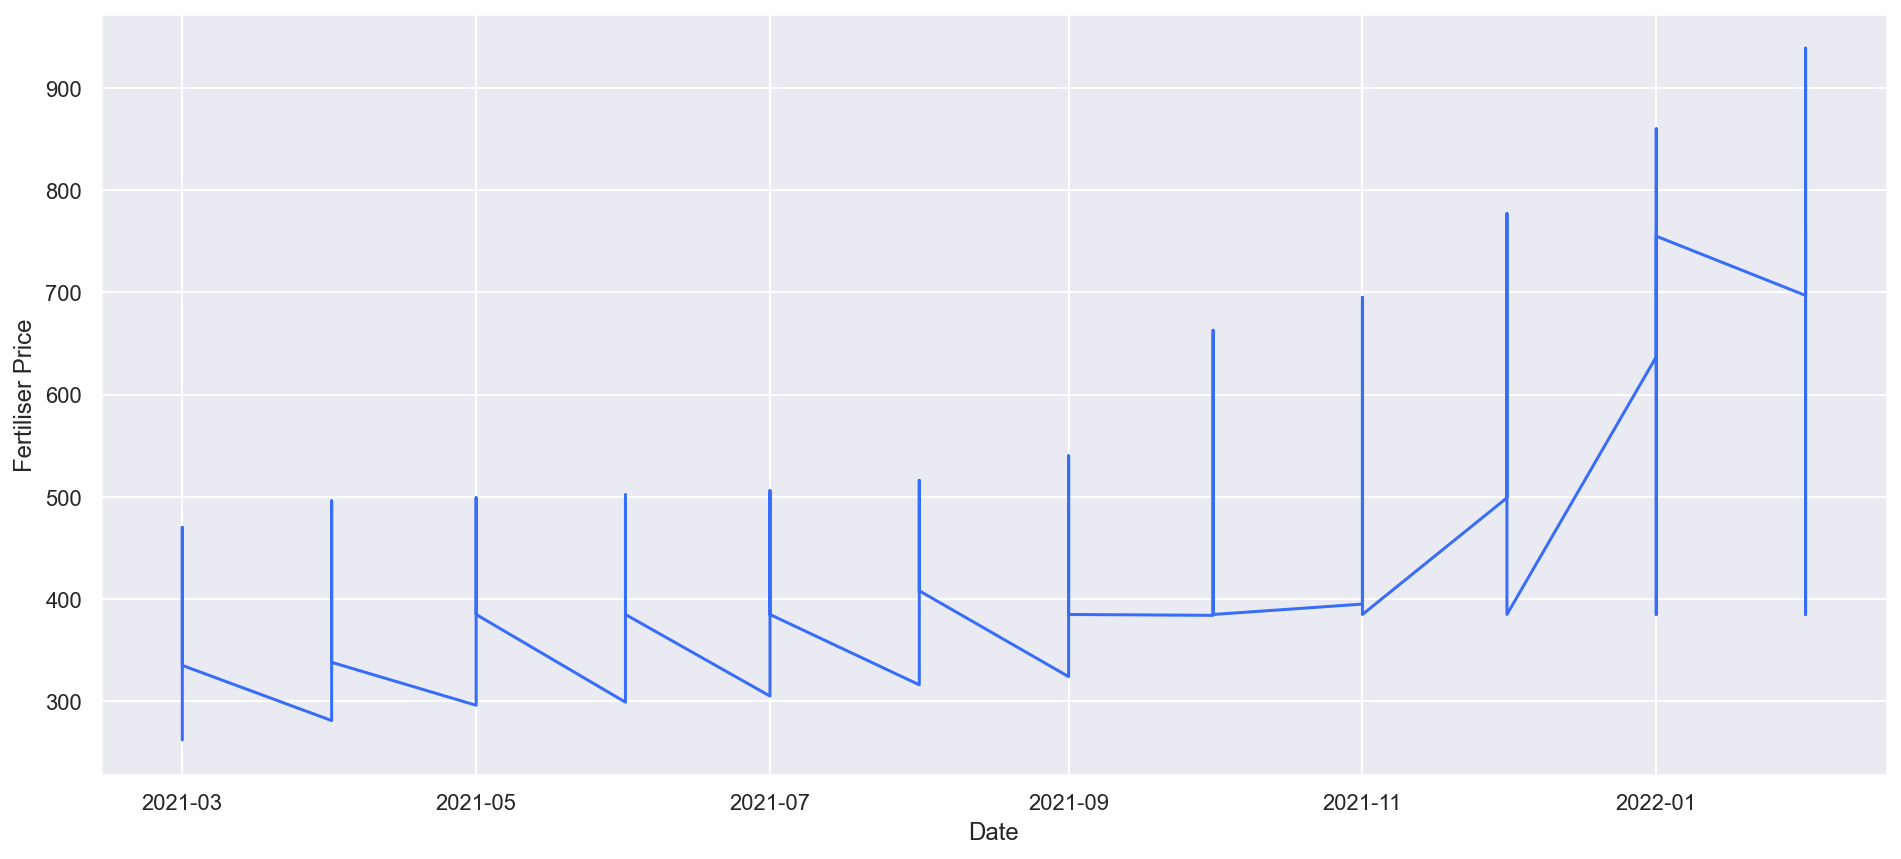

In [50]:
#Data Exploration
plt.figure(figsize=(16,7))
fig = plt.figure(1)
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Date')
ax1.set_ylabel('Fertiliser Price')
ax1.plot( df_oneyear['date'],df_oneyear['fertiliser_price'])

<Figure size 1152x504 with 0 Axes>

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

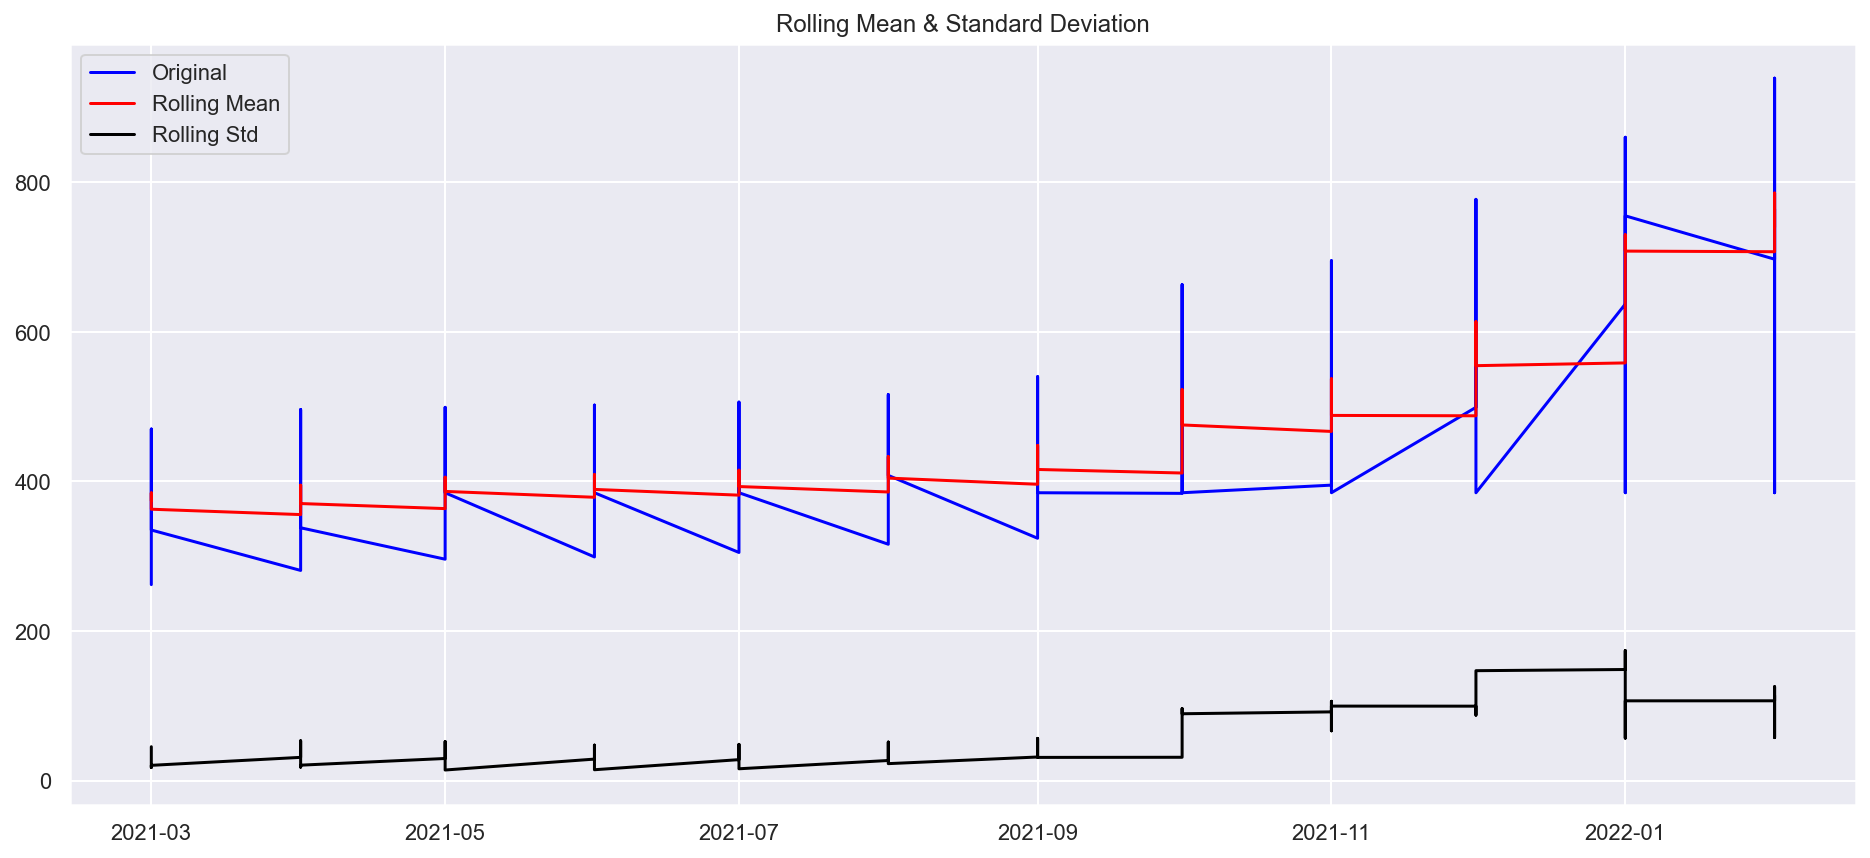

In [51]:
#Determing rolling statistics
rolLmean = df_oneyear['fertiliser_price'].rolling(12).mean()
rolLstd = df_oneyear['fertiliser_price'].rolling(12).std()

plt.figure(figsize=(16,7))
fig = plt.figure(1)

#Plot rolling statistics:
orig = plt.plot(df_oneyear['fertiliser_price'], color='blue',label='Original')
mean = plt.plot(rolLmean, color='red', label='Rolling Mean')
std = plt.plot(rolLstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

<Figure size 1152x504 with 0 Axes>

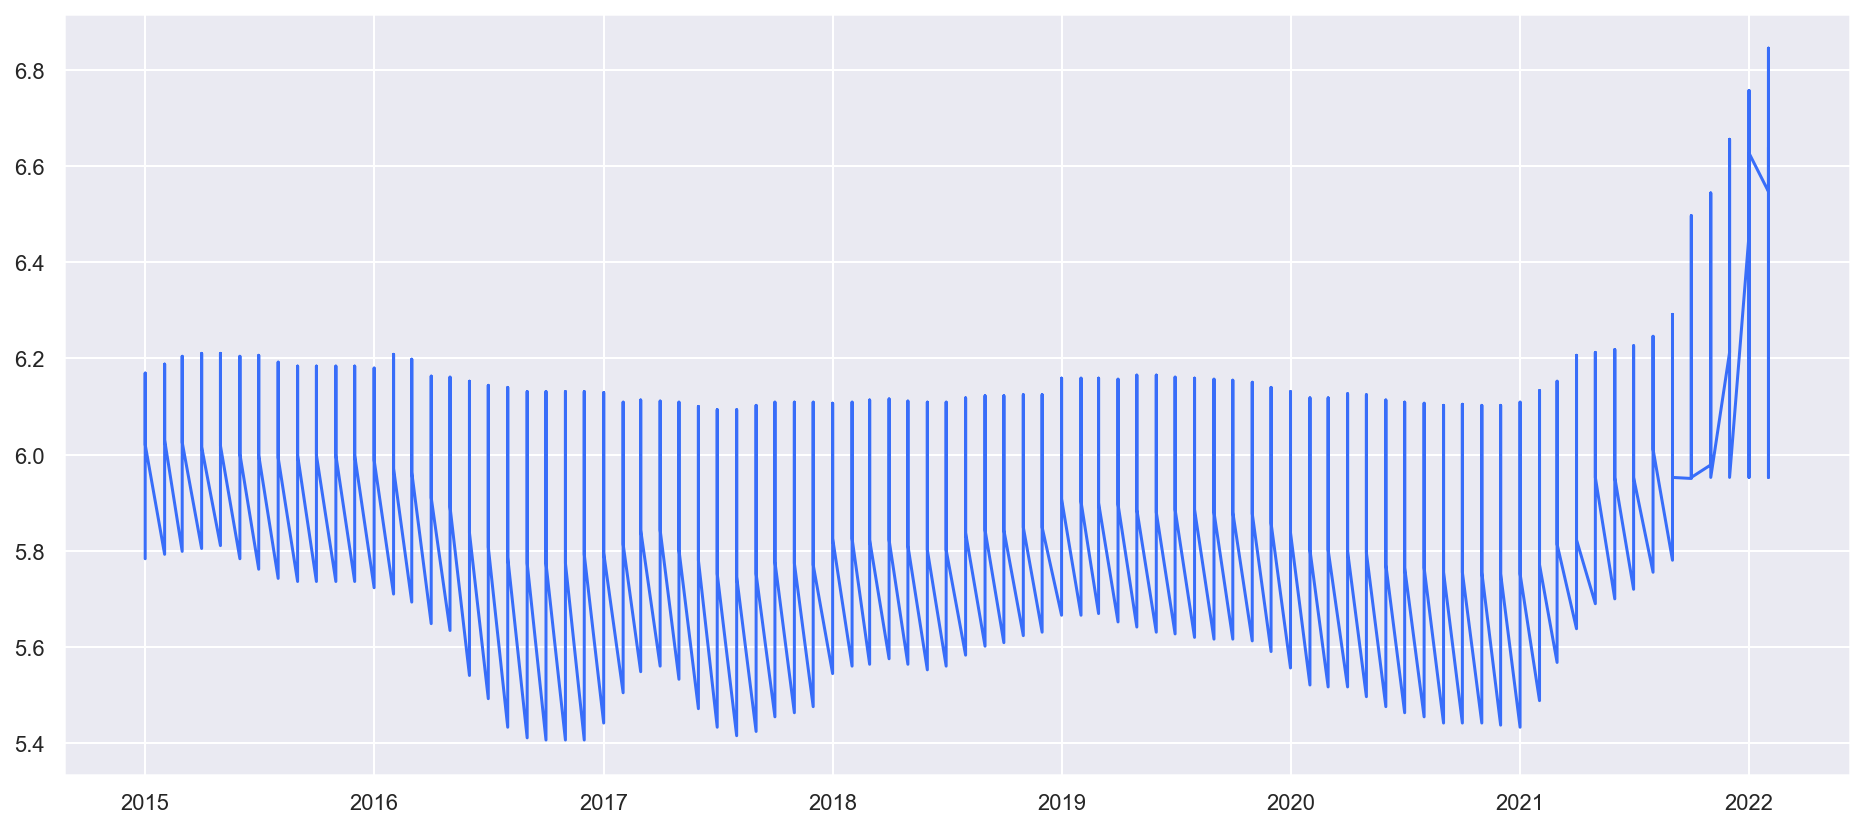

In [52]:
#Lets try transformation
plt.figure(figsize=(16,7))
fig = plt.figure(1)

import numpy as np
ts_log = np.log(df_all['fertiliser_price'])
plt.plot(ts_log)

In [53]:
#Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, freq=1, model = 'multiplicative')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16,7))
fig = plt.figure(1)

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

TypeError: seasonal_decompose() got an unexpected keyword argument 'freq'

<Figure size 1152x504 with 0 Axes>

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

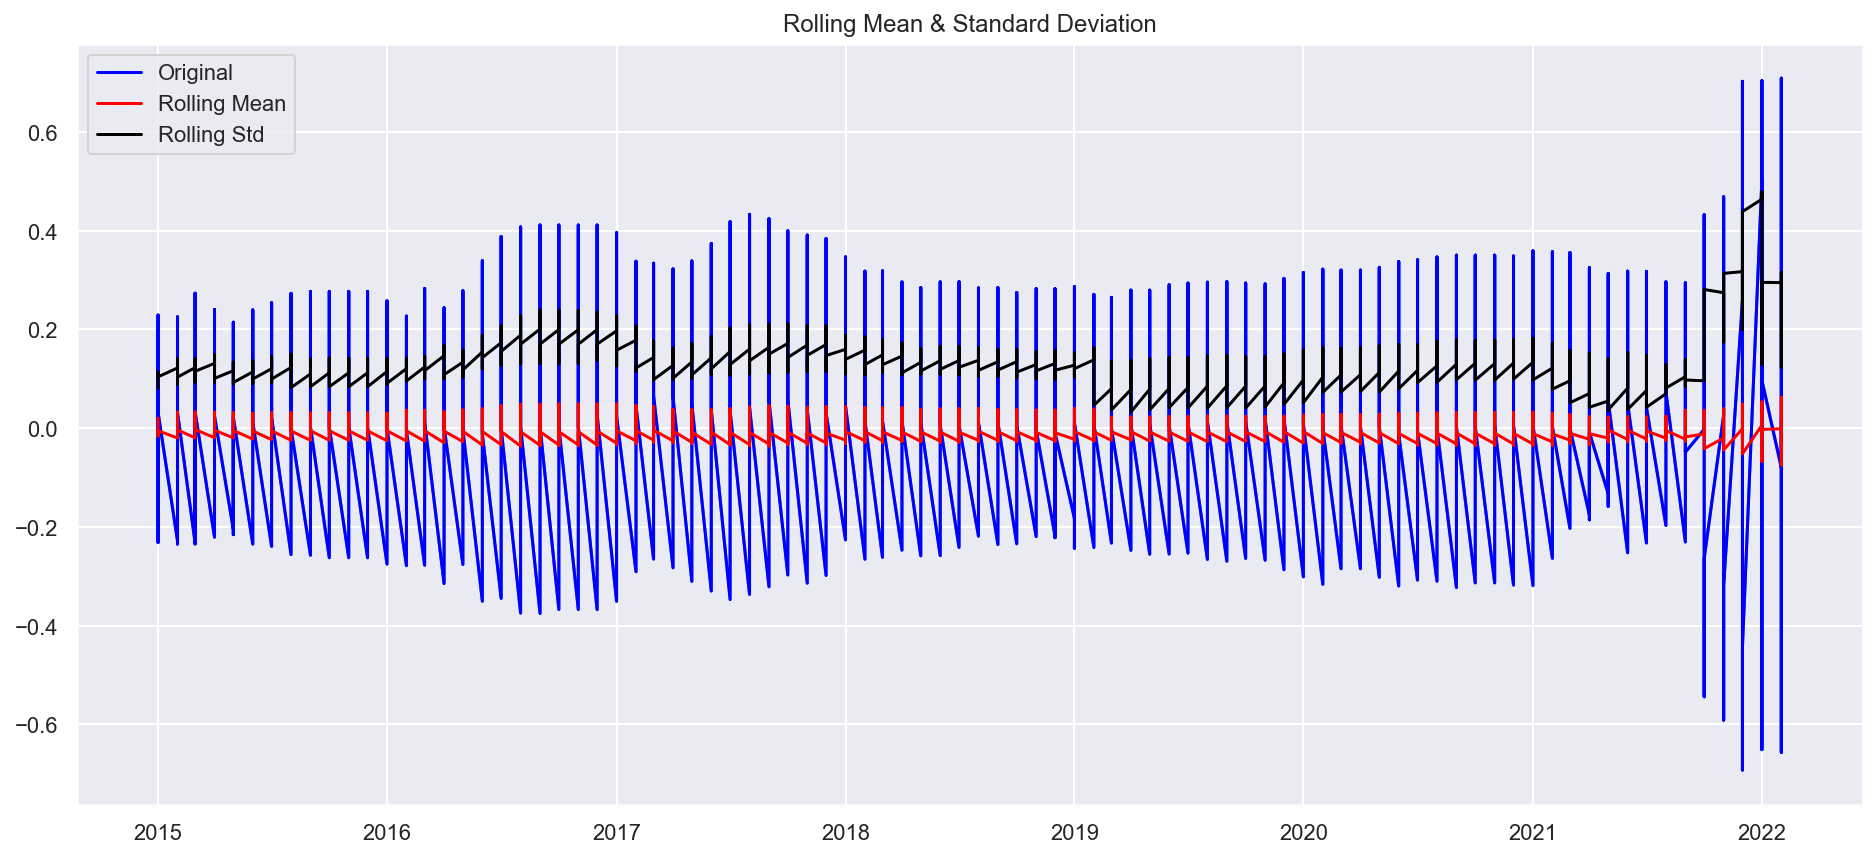

In [54]:
#Lets try differencing
plt.figure(figsize=(16,7))
fig = plt.figure(1)
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

#Determing rolling statistics
rolLmean = ts_log_diff.rolling(12).mean()
rolLstd = ts_log_diff.rolling(12).std()




#Plot rolling statistics:
orig = plt.plot(ts_log_diff, color='blue',label='Original')
mean = plt.plot(rolLmean, color='red', label='Rolling Mean')
std = plt.plot(rolLstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [55]:
df_fertiliser.sort_index(inplace= True)

In [56]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20)

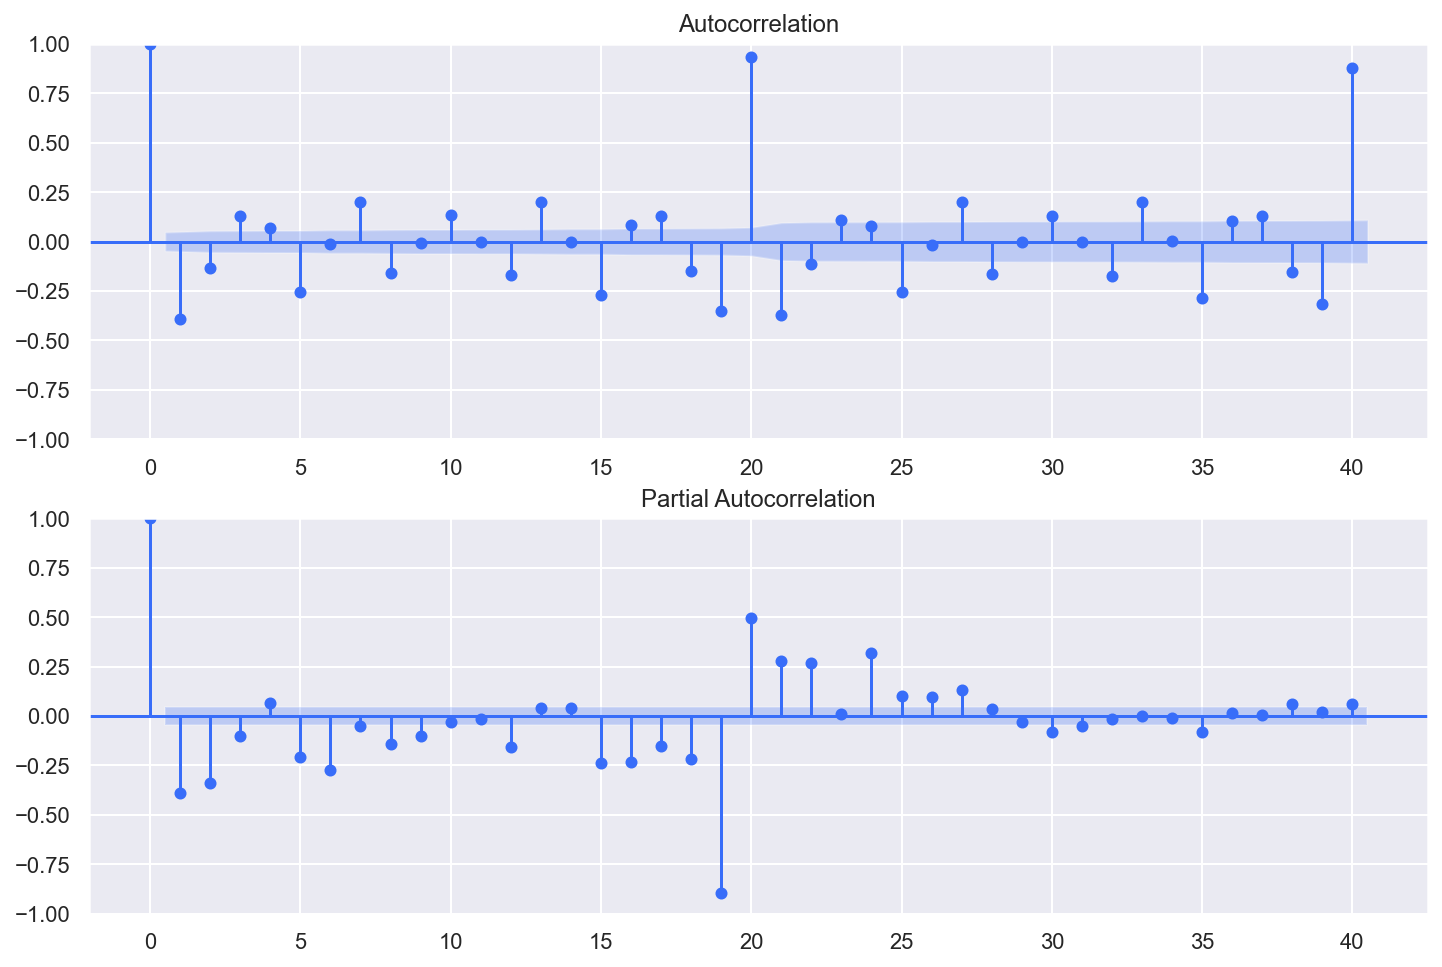

In [57]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_log_diff.dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_log_diff.dropna(),lags=40,ax=ax2)

In [58]:
from statsmodels.tsa.arima.model import ARIMA

In [59]:
type(ts_log_diff)

pandas.core.series.Series

In [60]:
#ts_log_diff.dropna()
ts_log_diff = ts_log_diff[~ts_log_diff.isnull()]

<Figure size 1152x576 with 0 Axes>

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


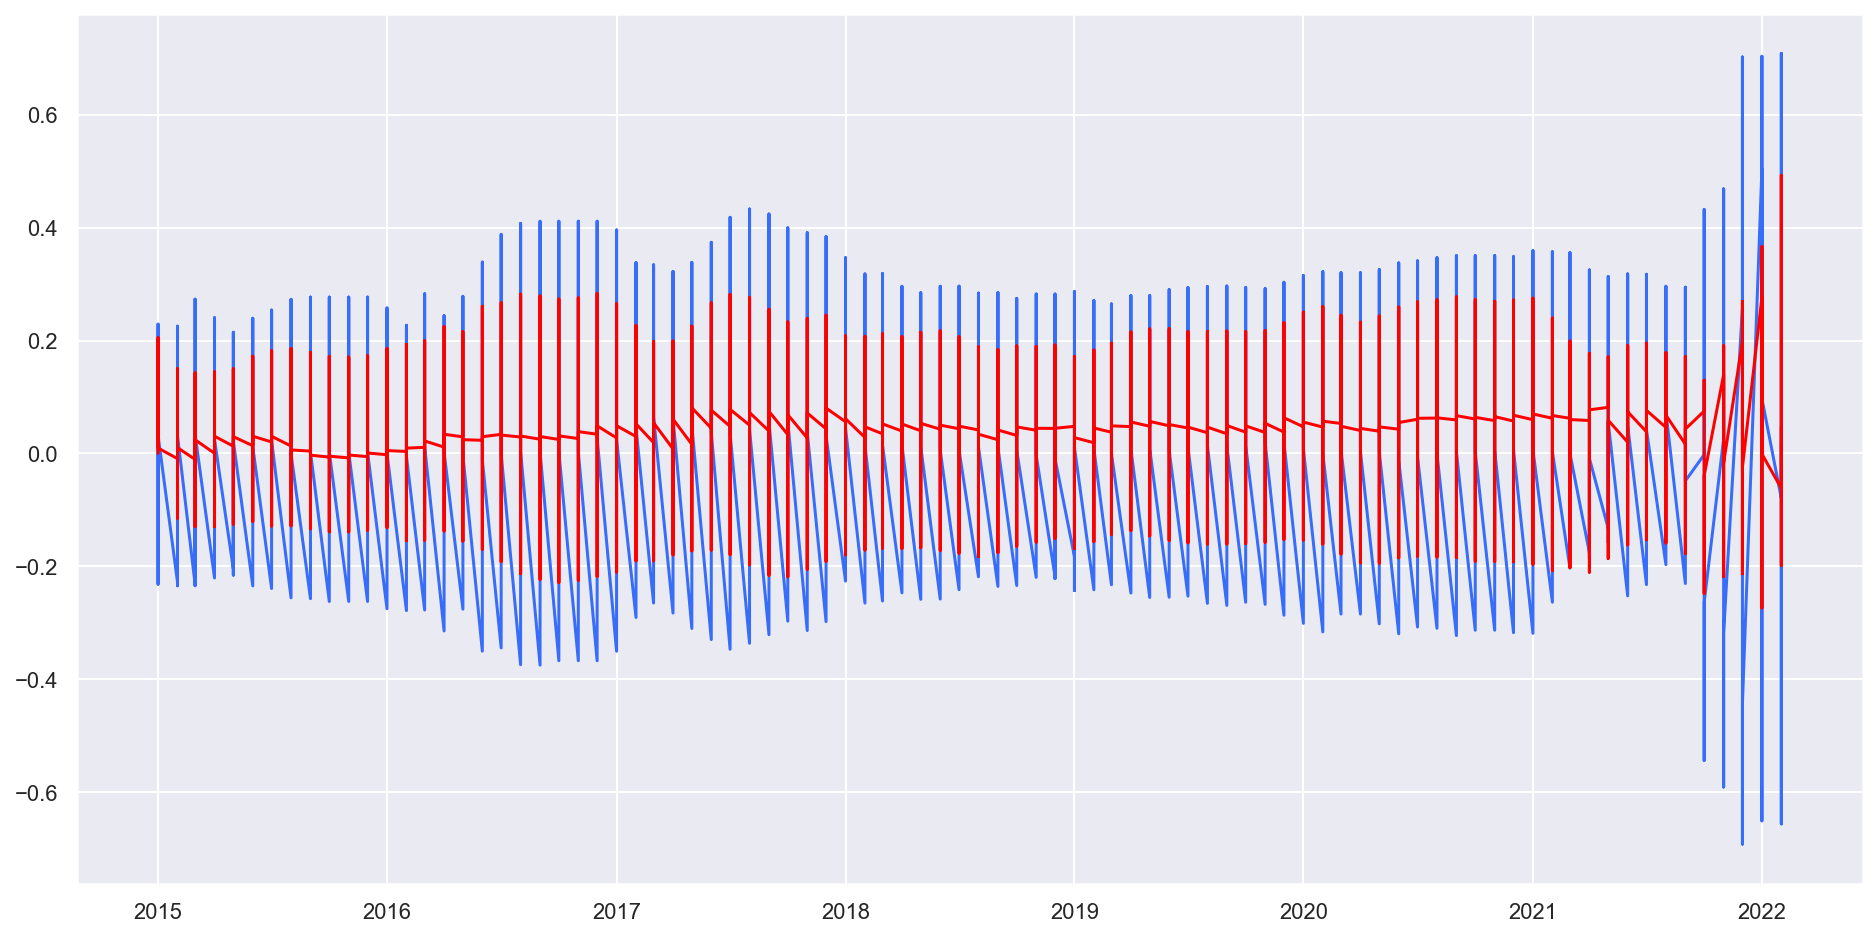

In [61]:
plt.figure(figsize=(16,8))
#ts_log_diff.dropna(inplace=True)
model = ARIMA(ts_log_diff, order=(2,1,2))  
results_ARIMA = model.fit()  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')

In [62]:
ARIMA_diff_predictions = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(ARIMA_diff_predictions.head())

date
2015-01-01    0.000000
2015-01-01    0.205136
2015-01-01    0.144599
2015-01-01    0.109760
2015-01-01    0.089375
dtype: float64


In [63]:
ARIMA_diff_predictions_cumsum = ARIMA_diff_predictions.cumsum()
print(ARIMA_diff_predictions_cumsum.head())

date
2015-01-01    0.000000
2015-01-01    0.205136
2015-01-01    0.349736
2015-01-01    0.459495
2015-01-01    0.548870
dtype: float64


In [64]:
ARIMA_log_prediction = pd.Series(ts_log.iloc[0], index=ts_log.index)
ARIMA_log_prediction = ARIMA_log_prediction.add(ARIMA_diff_predictions_cumsum,fill_value=0)
ARIMA_log_prediction.head()

date
2015-01-01    5.783825
2015-01-01    5.988961
2015-01-01    6.133561
2015-01-01    6.243320
2015-01-01    6.332696
dtype: float64

<Figure size 864x576 with 0 Axes>

TypeError: '<' not supported between instances of 'Timestamp' and 'int'

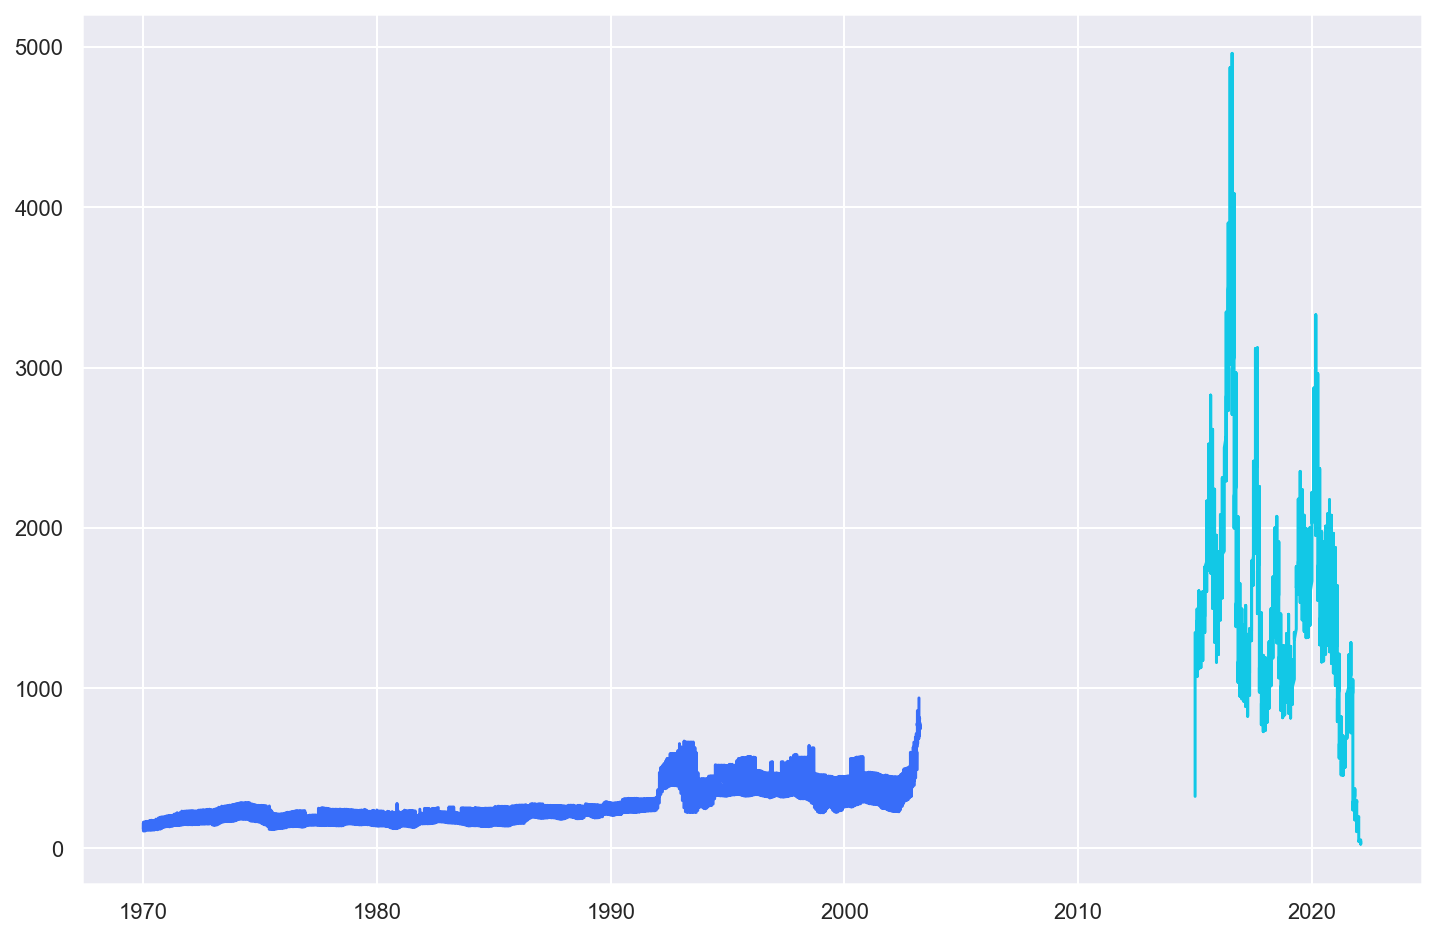

In [65]:
plt.figure(figsize=(12,8))
predictions_ARIMA = np.exp(ARIMA_log_prediction)
plt.plot(df_fertiliser['value'])
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-df_fertiliser['value'])**2)/len(df_fertiliser['value'])))

# Sentiment analysis of tweets

In [66]:
df_tweets

,Unnamed: 0,Datetime,Tweet Id,Text
0,0,2022-05-21 07:18:59+00:00,1527911820035497984,Milk prices soar for April supplies\nhttps://t.co/VRYKNlPESf
1,1,2022-05-20 17:58:36+00:00,1527710395288494085,"@invest_ez Beef prices are great, milk is pretty good, this adds up to increase in production this &amp; next year and when the obvious happens an appeal for help to their obliging insurance company (Dept of Ag!) Happens every time. (Don't get me wrong I think farming and farmers are great)"
2,2,2022-05-19 20:18:59+00:00,1527383338587000832,"A boost for live exports, beef prices, Kerry Co-op, milk prices and the ongoing difficulties in the pig sector feature on this week's podcast.\nhttps://t.co/nOGfYy6CZL"
3,3,2022-05-19 16:49:59+00:00,1527330740232343552,'Unless processors up their prices for organic cattle there is little hope of enticing livestock farmers to switch' https://t.co/GytSD6zlyv
4,4,2022-05-19 11:25:56+00:00,1527249190019026944,Pig farmers have spent the night protesting at a meat processing plant in Drogheda as part of an ongoing campaign to secure higher prices for pig meat.\n\nhttps://t.co/429Pgzsxx9
5,5,2022-05-19 07:15:02+00:00,1527186047108534272,Farmers told to expect an increase in charges this year because of “record high” fuel prices and escalating labour and machinery costs.\nhttps://t.co/aKj3mU44nq
6,6,2022-05-17 21:09:59+00:00,1526671395865894914,Check out the prices and photos from the Angus sale in Carrick at the weekend. Read more here.\nhttps://t.co/4Ppao2cfau
7,7,2022-05-17 18:09:59+00:00,1526626097932148737,The latest USDA World Agricultural Supply and Demand Estimates report suggests that grain prices will continue to be supported in 2022 and 2023 due to tight supply.\nhttps://t.co/FRycrlFzok
8,8,2022-05-15 00:54:58+00:00,1525640848905576449,I perfectly timed my purchase of peak CRV and CVX prices hence the salt.
9,9,2022-05-20 14:09:52+00:00,1527652834027659265,The increase in energy and fertiliser prices is putting the next global harvest at risk... https://t.co/2jed2iK3au


In [67]:
# convert to datetime
df_tweets['Datetime'] = pd.to_datetime(df_tweets['Datetime']).dt.date

In [68]:
# convert the date column to date format
df_tweets['Datetime'] = df_tweets['Datetime'].apply(pd.to_datetime)
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  47 non-null     int64         
 1   Datetime    47 non-null     datetime64[ns]
 2   Tweet Id    47 non-null     int64         
 3   Text        47 non-null     object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 1.6+ KB


In [69]:
df_tweets = df_tweets[(df_tweets['Datetime'] > "2021-01-01") & (df_tweets['Datetime'] < "2022-05-22")]

In [70]:
#get the word count of the tweet
df_tweets["word_count"] = df_tweets["Text"].apply(lambda x: len(str(x).split()))

In [71]:
#get the word count of the tweet
df_tweets["char_count"] = df_tweets["Text"].str.len()

### Natural Language processing

### Topic modelling
https://www.youtube.com/watch?v=NYkbqzTlW3w
https://www.youtube.com/watch?v=VraAbgAoYSk

In [72]:
#https://www.nltk.org/
import nltk #natural langugage toolkit

In [73]:
#download stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ritaraher/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [74]:
from nltk.corpus import stopwords
#remove stopwords
stop = stopwords.words("english")

In [75]:
# counting stop words
#stop words
df_tweets["stopwords"]= df_tweets["Text"].apply(lambda x: len([x for x in x.split() if x in stop]))

In [76]:
#count hashtags
df_tweets["hashtag"]= df_tweets["Text"].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))

In [77]:
# Apply text cleaning techniques
import re
import string

def clean_text_round1(text):
    text = text.lower()                                              #lowercase
    text = re.sub('\[.*?\]', '', text)                               #remove the twitter handle
    text = re.sub('@[^\s]+', '', text)                               # remove text in square brackets
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  # remove punctuation
    text = re.sub('\w*\d\w*', '', text)                              #remove words containing numbers
    text = re.sub('\n', '', text)                                    # remove \n
    return text

round1 = lambda x: clean_text_round1(x)

In [78]:
# Let's take a look at the updated text
df_tweets['tweet_clean'] = df_tweets.Text.apply(round1)
df_tweets

,Unnamed: 0,Datetime,Tweet Id,Text,word_count,char_count,stopwords,hashtag,tweet_clean
0,0,2022-05-21,1527911820035497984,Milk prices soar for April supplies\nhttps://t.co/VRYKNlPESf,7,59,1,0,milk prices soar for april supplieshttpstcovryknlpesf
1,1,2022-05-20,1527710395288494085,"@invest_ez Beef prices are great, milk is pretty good, this adds up to increase in production this &amp; next year and when the obvious happens an appeal for help to their obliging insurance company (Dept of Ag!) Happens every time. (Don't get me wrong I think farming and farmers are great)",51,291,18,0,beef prices are great milk is pretty good this adds up to increase in production this amp next year and when the obvious happens an appeal for help to their obliging insurance company dept of ag happens every time dont get me wrong i think farming and farmers are great
2,2,2022-05-19,1527383338587000832,"A boost for live exports, beef prices, Kerry Co-op, milk prices and the ongoing difficulties in the pig sector feature on this week's podcast.\nhttps://t.co/nOGfYy6CZL",25,166,7,0,a boost for live exports beef prices kerry coop milk prices and the ongoing difficulties in the pig sector feature on this weeks podcast
3,3,2022-05-19,1527330740232343552,'Unless processors up their prices for organic cattle there is little hope of enticing livestock farmers to switch' https://t.co/GytSD6zlyv,19,139,7,0,unless processors up their prices for organic cattle there is little hope of enticing livestock farmers to switch
4,4,2022-05-19,1527249190019026944,Pig farmers have spent the night protesting at a meat processing plant in Drogheda as part of an ongoing campaign to secure higher prices for pig meat.\n\nhttps://t.co/429Pgzsxx9,28,176,10,0,pig farmers have spent the night protesting at a meat processing plant in drogheda as part of an ongoing campaign to secure higher prices for pig meat
5,5,2022-05-19,1527186047108534272,Farmers told to expect an increase in charges this year because of “record high” fuel prices and escalating labour and machinery costs.\nhttps://t.co/aKj3mU44nq,23,159,8,0,farmers told to expect an increase in charges this year because of “record high” fuel prices and escalating labour and machinery costs
6,6,2022-05-17,1526671395865894914,Check out the prices and photos from the Angus sale in Carrick at the weekend. Read more here.\nhttps://t.co/4Ppao2cfau,19,118,9,0,check out the prices and photos from the angus sale in carrick at the weekend read more here
7,7,2022-05-17,1526626097932148737,The latest USDA World Agricultural Supply and Demand Estimates report suggests that grain prices will continue to be supported in 2022 and 2023 due to tight supply.\nhttps://t.co/FRycrlFzok,28,188,8,0,the latest usda world agricultural supply and demand estimates report suggests that grain prices will continue to be supported in and due to tight supplyhttpstcofrycrlfzok
8,8,2022-05-15,1525640848905576449,I perfectly timed my purchase of peak CRV and CVX prices hence the salt.,14,72,4,0,i perfectly timed my purchase of peak crv and cvx prices hence the salt
9,9,2022-05-20,1527652834027659265,The increase in energy and fertiliser prices is putting the next global harvest at risk... https://t.co/2jed2iK3au,16,114,5,0,the increase in energy and fertiliser prices is putting the next global harvest at risk


In [79]:
#removing stop words from tweet clean
df_tweets["tweet_clean"]= df_tweets["tweet_clean"].apply(lambda x : " ".join(x for x in x.split() if x not in stop))

### Sentiment Analysis with TextBlob

In [80]:
##semantic analysis
from textblob import TextBlob
df_tweets["tweet_clean"][:5].apply(lambda x : TextBlob(x).sentiment)

#   (-0.5, 1.0)
# sentiment of being negative because of the -, subjective

0    (0.0, 0.0)                                
1    (0.2928571428571428, 0.6428571428571429)  
2    (0.13636363636363635, 0.5)                
3    (-0.1875, 0.5)                            
4    (0.18333333333333335, 0.39999999999999997)
Name: tweet_clean, dtype: object

In [81]:
df_tweets["polarity"]= df_tweets["tweet_clean"].apply(lambda x : TextBlob(x).sentiment[0])

#   (-0.5, 1.0)
# sentiment of being negative because of the -, subjective

In [82]:
df_tweets["subjectivity"]= df_tweets["tweet_clean"].apply(lambda x : TextBlob(x).sentiment[1])

In [83]:
df_tweets

,Unnamed: 0,Datetime,Tweet Id,Text,word_count,char_count,stopwords,hashtag,tweet_clean,polarity,subjectivity
0,0,2022-05-21,1527911820035497984,Milk prices soar for April supplies\nhttps://t.co/VRYKNlPESf,7,59,1,0,milk prices soar april supplieshttpstcovryknlpesf,0.000000,0.000000
1,1,2022-05-20,1527710395288494085,"@invest_ez Beef prices are great, milk is pretty good, this adds up to increase in production this &amp; next year and when the obvious happens an appeal for help to their obliging insurance company (Dept of Ag!) Happens every time. (Don't get me wrong I think farming and farmers are great)",51,291,18,0,beef prices great milk pretty good adds increase production amp next year obvious happens appeal help obliging insurance company dept ag happens every time dont get wrong think farming farmers great,0.292857,0.642857
2,2,2022-05-19,1527383338587000832,"A boost for live exports, beef prices, Kerry Co-op, milk prices and the ongoing difficulties in the pig sector feature on this week's podcast.\nhttps://t.co/nOGfYy6CZL",25,166,7,0,boost live exports beef prices kerry coop milk prices ongoing difficulties pig sector feature weeks podcast,0.136364,0.500000
3,3,2022-05-19,1527330740232343552,'Unless processors up their prices for organic cattle there is little hope of enticing livestock farmers to switch' https://t.co/GytSD6zlyv,19,139,7,0,unless processors prices organic cattle little hope enticing livestock farmers switch,-0.187500,0.500000
4,4,2022-05-19,1527249190019026944,Pig farmers have spent the night protesting at a meat processing plant in Drogheda as part of an ongoing campaign to secure higher prices for pig meat.\n\nhttps://t.co/429Pgzsxx9,28,176,10,0,pig farmers spent night protesting meat processing plant drogheda part ongoing campaign secure higher prices pig meat,0.183333,0.400000
5,5,2022-05-19,1527186047108534272,Farmers told to expect an increase in charges this year because of “record high” fuel prices and escalating labour and machinery costs.\nhttps://t.co/aKj3mU44nq,23,159,8,0,farmers told expect increase charges year “record high” fuel prices escalating labour machinery costs,0.160000,0.540000
6,6,2022-05-17,1526671395865894914,Check out the prices and photos from the Angus sale in Carrick at the weekend. Read more here.\nhttps://t.co/4Ppao2cfau,19,118,9,0,check prices photos angus sale carrick weekend read,0.000000,0.000000
7,7,2022-05-17,1526626097932148737,The latest USDA World Agricultural Supply and Demand Estimates report suggests that grain prices will continue to be supported in 2022 and 2023 due to tight supply.\nhttps://t.co/FRycrlFzok,28,188,8,0,latest usda world agricultural supply demand estimates report suggests grain prices continue supported due tight supplyhttpstcofrycrlfzok,0.065476,0.520238
8,8,2022-05-15,1525640848905576449,I perfectly timed my purchase of peak CRV and CVX prices hence the salt.,14,72,4,0,perfectly timed purchase peak crv cvx prices hence salt,1.000000,1.000000
9,9,2022-05-20,1527652834027659265,The increase in energy and fertiliser prices is putting the next global harvest at risk... https://t.co/2jed2iK3au,16,114,5,0,increase energy fertiliser prices putting next global harvest risk,0.000000,0.000000


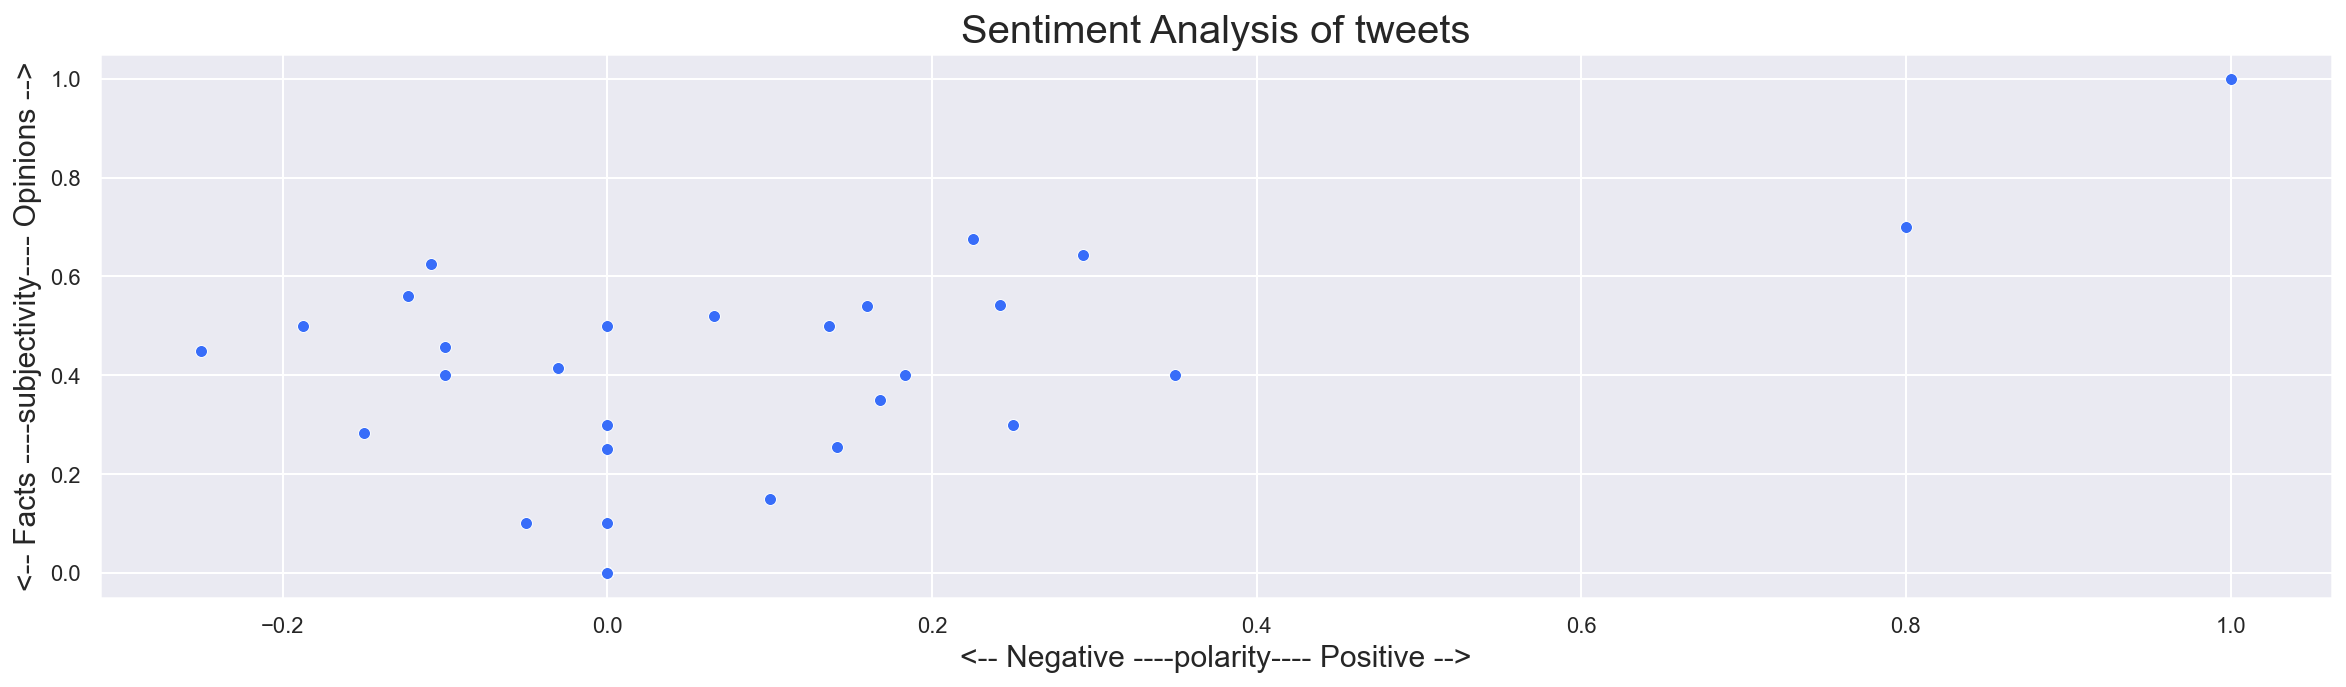

In [84]:
#set to seaborn
sns.set()
#palette
sns.set_palette('rainbow');
#plot size
plt.figure(figsize=(20, 5));  

sns.scatterplot(data=df_tweets, x="polarity", y="subjectivity")

plt.title("Sentiment Analysis of tweets", fontsize=20);
plt.xlabel('<-- Negative ----polarity---- Positive -->', fontsize=15);
plt.ylabel('<-- Facts ----subjectivity---- Opinions -->', fontsize=15);

plt.show();

### Document term matrix

https://analyticsindiamag.com/a-guide-to-term-document-matrix-with-its-implementation-in-r-and-python/

In [85]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words

from sklearn.feature_extraction.text import CountVectorizer

# create a count vectorizer object
cv = CountVectorizer(stop_words="english")

# fit the count vectorizer using the text data
data_cv = cv.fit_transform(df_tweets['tweet_clean'])
data_dtm =pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())

# Pickle it for later use
import pickle
pickle.dump(cv, open("../data/cv_stop.pkl", "wb"))

data_dtm

,abundance,acid,add,adding,adds,affected,ag,agricultural,agriculture,algae,...,wartorn,week,weekend,weeks,woke,world,wouldn,wrong,year,yrs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
#Gensism Python framework for fast Vector Space Modelling
from gensim import matutils, models
#ndustrial-strength Natural Language Processing (NLP) in Python
import scipy.sparse

### Topic modelling

In [87]:
# One of the required inputs is a term-document matrix
data_dtm = data_dtm.transpose()
data_dtm.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
abundance,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
acid,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
add,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
adding,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
adds,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
# turn term matrix into a sparse matrix
sparse_counts = scipy.sparse.csr_matrix(data_dtm)
#Convert a Scipy.sparse vector into the Gensim bag-of-words format
corpus = matutils.Sparse2Corpus(sparse_counts)

In [89]:
# Gensim also requires dictionary of the all terms and their respective location in the term-document matrix
#cv = pickle.load(open("../data/cv_stop.pkl", "rb"))

In [90]:
# collect the vocabulary items used in the count vectorizer
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

In [91]:
# Train the model on the corpus.
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=10)
lda.print_topics()

[(0,
  '0.027*"prices" + 0.025*"fertiliser" + 0.013*"farmers" + 0.008*"year" + 0.008*"increase" + 0.008*"good" + 0.008*"food" + 0.008*"fully" + 0.008*"farming" + 0.006*"ongoing"'),
 (1,
  '0.026*"fertiliser" + 0.021*"prices" + 0.011*"make" + 0.009*"global" + 0.009*"fuel" + 0.009*"war" + 0.009*"stay" + 0.009*"fuelled" + 0.009*"sent" + 0.009*"change"')]

In [92]:
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=3, passes=10)
lda.print_topics()

[(0,
  '0.033*"fertiliser" + 0.021*"prices" + 0.013*"day" + 0.013*"stay" + 0.013*"make" + 0.013*"food" + 0.010*"soil" + 0.010*"cost" + 0.010*"people" + 0.010*"feed"'),
 (1,
  '0.025*"fertiliser" + 0.023*"prices" + 0.017*"war" + 0.014*"fuel" + 0.012*"global" + 0.012*"fuelled" + 0.012*"sent" + 0.012*"change" + 0.012*"cooking" + 0.012*"ukraine"'),
 (2,
  '0.029*"prices" + 0.017*"fertiliser" + 0.012*"farmers" + 0.012*"amp" + 0.009*"increase" + 0.009*"year" + 0.009*"pig" + 0.009*"milk" + 0.009*"beef" + 0.009*"make"')]

In [93]:
# LDA for num_topics = 4
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=4, passes=10)
lda.print_topics()

[(0,
  '0.023*"fertiliser" + 0.015*"farmers" + 0.010*"spend" + 0.010*"soil" + 0.010*"increased" + 0.010*"months" + 0.006*"grow" + 0.006*"agriculture" + 0.006*"ireland" + 0.006*"chatting"'),
 (1,
  '0.042*"prices" + 0.032*"fertiliser" + 0.013*"global" + 0.013*"food" + 0.010*"diesel" + 0.010*"fuel" + 0.007*"live" + 0.007*"climate" + 0.007*"risk" + 0.007*"putting"'),
 (2,
  '0.032*"fertiliser" + 0.015*"war" + 0.015*"fully" + 0.015*"prices" + 0.011*"amp" + 0.011*"good" + 0.008*"fuel" + 0.008*"day" + 0.008*"ukraine" + 0.008*"oils"'),
 (3,
  '0.034*"prices" + 0.025*"make" + 0.017*"farmers" + 0.017*"stay" + 0.017*"year" + 0.009*"cost" + 0.009*"day" + 0.009*"pig" + 0.009*"record" + 0.009*"feed"')]

### Topic Modeling - Attempt #2 (Nouns Only)

In [94]:
# Let's create a function to pull out nouns from a string of text
from nltk import word_tokenize, pos_tag

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [95]:
# Apply the nouns function to the transcripts to filter only on nouns
df_tweets['data_nouns'] = pd.DataFrame(df_tweets.tweet_clean.apply(nouns))
df_tweets

,Unnamed: 0,Datetime,Tweet Id,Text,word_count,char_count,stopwords,hashtag,tweet_clean,polarity,subjectivity,data_nouns
0,0,2022-05-21,1527911820035497984,Milk prices soar for April supplies\nhttps://t.co/VRYKNlPESf,7,59,1,0,milk prices soar april supplieshttpstcovryknlpesf,0.000000,0.000000,milk prices april
1,1,2022-05-20,1527710395288494085,"@invest_ez Beef prices are great, milk is pretty good, this adds up to increase in production this &amp; next year and when the obvious happens an appeal for help to their obliging insurance company (Dept of Ag!) Happens every time. (Don't get me wrong I think farming and farmers are great)",51,291,18,0,beef prices great milk pretty good adds increase production amp next year obvious happens appeal help obliging insurance company dept ag happens every time dont get wrong think farming farmers great,0.292857,0.642857,beef prices milk increase production year appeal help insurance company time farmers
2,2,2022-05-19,1527383338587000832,"A boost for live exports, beef prices, Kerry Co-op, milk prices and the ongoing difficulties in the pig sector feature on this week's podcast.\nhttps://t.co/nOGfYy6CZL",25,166,7,0,boost live exports beef prices kerry coop milk prices ongoing difficulties pig sector feature weeks podcast,0.136364,0.500000,exports beef prices milk prices difficulties sector feature weeks podcast
3,3,2022-05-19,1527330740232343552,'Unless processors up their prices for organic cattle there is little hope of enticing livestock farmers to switch' https://t.co/GytSD6zlyv,19,139,7,0,unless processors prices organic cattle little hope enticing livestock farmers switch,-0.187500,0.500000,processors prices cattle livestock farmers
4,4,2022-05-19,1527249190019026944,Pig farmers have spent the night protesting at a meat processing plant in Drogheda as part of an ongoing campaign to secure higher prices for pig meat.\n\nhttps://t.co/429Pgzsxx9,28,176,10,0,pig farmers spent night protesting meat processing plant drogheda part ongoing campaign secure higher prices pig meat,0.183333,0.400000,pig farmers night meat processing plant part campaign secure prices meat
5,5,2022-05-19,1527186047108534272,Farmers told to expect an increase in charges this year because of “record high” fuel prices and escalating labour and machinery costs.\nhttps://t.co/aKj3mU44nq,23,159,8,0,farmers told expect increase charges year “record high” fuel prices escalating labour machinery costs,0.160000,0.540000,farmers increase charges year record ” fuel prices machinery costs
6,6,2022-05-17,1526671395865894914,Check out the prices and photos from the Angus sale in Carrick at the weekend. Read more here.\nhttps://t.co/4Ppao2cfau,19,118,9,0,check prices photos angus sale carrick weekend read,0.000000,0.000000,check prices sale weekend read
7,7,2022-05-17,1526626097932148737,The latest USDA World Agricultural Supply and Demand Estimates report suggests that grain prices will continue to be supported in 2022 and 2023 due to tight supply.\nhttps://t.co/FRycrlFzok,28,188,8,0,latest usda world agricultural supply demand estimates report suggests grain prices continue supported due tight supplyhttpstcofrycrlfzok,0.065476,0.520238,world supply demand grain prices supplyhttpstcofrycrlfzok
8,8,2022-05-15,1525640848905576449,I perfectly timed my purchase of peak CRV and CVX prices hence the salt.,14,72,4,0,perfectly timed purchase peak crv cvx prices hence salt,1.000000,1.000000,purchase peak crv cvx prices hence salt
9,9,2022-05-20,1527652834027659265,The increase in energy and fertiliser prices is putting the next global harvest at risk... https://t.co/2jed2iK3au,16,114,5,0,increase energy fertiliser prices putting next global harvest risk,0.000000,0.000000,increase energy fertiliser prices harvest risk


In [96]:
df_tweets.data_nouns

0     milk prices april                                                                                                                                              
1     beef prices milk increase production year appeal help insurance company time farmers                                                                           
2     exports beef prices milk prices difficulties sector feature weeks podcast                                                                                      
3     processors prices cattle livestock farmers                                                                                                                     
4     pig farmers night meat processing plant part campaign secure prices meat                                                                                       
5     farmers increase charges year record ” fuel prices machinery costs                                                                                             
6   

In [97]:
# Create a new document-term matrix using only nouns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer

# Re-add the additional stop words since we are recreating the document-term matrix
add_stop_words = ['like', 'im', 'know', 'just', 'dont', 'thats', 'right', 'people',
                  'youre', 'got', 'gonna', 'time', 'think', 'yeah', 'said', 'amp', 'farm', 'farms']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate a document-term matrix with only nouns
cvn = CountVectorizer(stop_words=stop_words)
data_cvn = cvn.fit_transform(df_tweets.data_nouns)
data_dtmn = pd.DataFrame(data_cvn.toarray(), columns=cvn.get_feature_names())

data_dtmn

,abundance,acid,agriculture,algae,appeal,application,april,area,baaeedsales,bate,...,type,unit,urea,use,war,week,weekend,weeks,world,year
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
# Create the gensim corpus
corpusn = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmn.transpose()))

# Create the vocabulary dictionary
id2wordn = dict((v, k) for k, v in cvn.vocabulary_.items())

In [99]:
# Let's start with 2 topics
ldan = models.LdaModel(corpus=corpusn, num_topics=2, id2word=id2wordn, passes=10)
ldan.print_topics()

[(0,
  '0.047*"fertiliser" + 0.038*"prices" + 0.019*"farmers" + 0.015*"year" + 0.015*"increase" + 0.012*"soil" + 0.009*"record" + 0.008*"beef" + 0.008*"energy" + 0.008*"kids"'),
 (1,
  '0.056*"prices" + 0.019*"fertiliser" + 0.018*"day" + 0.017*"fuel" + 0.017*"war" + 0.017*"change" + 0.017*"drought" + 0.017*"oils" + 0.017*"grains" + 0.014*"food"')]

In [100]:
# Let's try topics = 3
ldan = models.LdaModel(corpus=corpusn, num_topics=3, id2word=id2wordn, passes=10)
ldan.print_topics()

[(0,
  '0.063*"prices" + 0.038*"farmers" + 0.029*"fertiliser" + 0.024*"year" + 0.020*"increase" + 0.015*"record" + 0.011*"beef" + 0.011*"meat" + 0.011*"diesel" + 0.011*"harvest"'),
 (1,
  '0.039*"fertiliser" + 0.038*"prices" + 0.033*"war" + 0.023*"fuel" + 0.023*"change" + 0.023*"oils" + 0.023*"drought" + 0.023*"grains" + 0.017*"food" + 0.017*"man"'),
 (2,
  '0.035*"fertiliser" + 0.032*"prices" + 0.029*"day" + 0.022*"soil" + 0.015*"feed" + 0.015*"inhibitors" + 0.015*"end" + 0.015*"cost" + 0.015*"business" + 0.015*"incur"')]

In [101]:
# Let's try 4 topics
ldan = models.LdaModel(corpus=corpusn, num_topics=4, id2word=id2wordn, passes=10)
ldan.print_topics()

[(0,
  '0.057*"prices" + 0.036*"farmers" + 0.036*"fertiliser" + 0.015*"milk" + 0.015*"production" + 0.015*"metals" + 0.015*"meat" + 0.015*"lads" + 0.015*"nuts" + 0.009*"supply"'),
 (1,
  '0.060*"prices" + 0.038*"day" + 0.036*"fertiliser" + 0.031*"war" + 0.031*"fuel" + 0.031*"drought" + 0.031*"change" + 0.031*"grains" + 0.031*"oils" + 0.016*"feed"'),
 (2,
  '0.037*"fertiliser" + 0.037*"prices" + 0.019*"year" + 0.013*"soil" + 0.013*"fuel" + 0.013*"war" + 0.013*"record" + 0.013*"man" + 0.013*"beef" + 0.013*"murderers"'),
 (3,
  '0.030*"food" + 0.030*"energy" + 0.030*"prices" + 0.023*"fertiliser" + 0.021*"increase" + 0.021*"months" + 0.021*"risk" + 0.021*"harvest" + 0.021*"eu" + 0.020*"price"')]

### Topic Modeling - Attempt #3 (Nouns and Adjectives)

In [102]:
# Let's create a function to pull out nouns from a string of text
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [103]:
# Apply the nouns function to the transcripts to filter only on nouns
df_tweets['data_nouns_adj'] = pd.DataFrame(df_tweets.tweet_clean.apply(nouns_adj))

In [104]:
# Create a new document-term matrix using only nouns and adjectives, also remove common words with max_df
cvna = CountVectorizer(stop_words=stop_words, max_df=.8)
data_cvna = cvna.fit_transform(df_tweets.data_nouns_adj)
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())

data_dtmna

,abundance,acid,agricultural,agriculture,algae,andy,angus,antrim,appeal,application,...,usda,use,war,wartorn,week,weekend,weeks,world,wrong,year
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
# Create the gensim corpus
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))

# Create the vocabulary dictionary
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())


In [106]:
# Let's start with 2 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=2, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.036*"prices" + 0.024*"fertiliser" + 0.018*"farmers" + 0.014*"year" + 0.009*"day" + 0.009*"good" + 0.009*"feed" + 0.009*"record" + 0.009*"beef" + 0.009*"milk"'),
 (1,
  '0.040*"fertiliser" + 0.034*"prices" + 0.018*"global" + 0.013*"war" + 0.013*"fuel" + 0.012*"ukraine" + 0.012*"drought" + 0.012*"grains" + 0.012*"climate" + 0.012*"change"')]

In [107]:
# Let's try 3 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=3, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.051*"prices" + 0.015*"food" + 0.012*"day" + 0.012*"feed" + 0.012*"farmers" + 0.012*"fertiliser" + 0.008*"eu" + 0.008*"meat" + 0.008*"sense" + 0.008*"record"'),
 (1,
  '0.030*"farmers" + 0.030*"prices" + 0.019*"year" + 0.018*"fertiliser" + 0.013*"increase" + 0.013*"good" + 0.013*"milk" + 0.013*"great" + 0.013*"lads" + 0.013*"nuts"'),
 (2,
  '0.061*"fertiliser" + 0.022*"war" + 0.022*"global" + 0.022*"prices" + 0.015*"fuel" + 0.015*"oils" + 0.015*"climate" + 0.015*"drought" + 0.015*"change" + 0.015*"ukraine"')]

In [108]:
# Let's try 4 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=4, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.027*"prices" + 0.021*"good" + 0.021*"fertiliser" + 0.014*"farmers" + 0.014*"man" + 0.014*"organic" + 0.014*"old" + 0.014*"turn" + 0.014*"decisions" + 0.014*"kids"'),
 (1,
  '0.034*"prices" + 0.027*"global" + 0.027*"fuel" + 0.027*"war" + 0.027*"ukraine" + 0.027*"climate" + 0.027*"drought" + 0.027*"oils" + 0.027*"grains" + 0.027*"change"'),
 (2,
  '0.040*"prices" + 0.029*"fertiliser" + 0.024*"farmers" + 0.020*"increase" + 0.017*"year" + 0.015*"food" + 0.015*"production" + 0.010*"nitric" + 0.010*"metals" + 0.010*"harvest"'),
 (3,
  '0.046*"fertiliser" + 0.036*"prices" + 0.019*"day" + 0.015*"soil" + 0.010*"fungal" + 0.010*"bacterial" + 0.010*"diesel" + 0.010*"inhibitors" + 0.010*"incur" + 0.010*"business"')]

### Identify Topics in Each Document

In [109]:
# final LDA model (for now)
ldana = models.LdaModel(corpus=corpusna, num_topics=2, id2word=id2wordna, passes=80)
ldana.print_topics()

[(0,
  '0.031*"prices" + 0.031*"fertiliser" + 0.015*"farmers" + 0.015*"day" + 0.010*"year" + 0.010*"beef" + 0.010*"milk" + 0.007*"feed" + 0.007*"production" + 0.007*"bacterial"'),
 (1,
  '0.038*"prices" + 0.033*"fertiliser" + 0.017*"war" + 0.017*"fuel" + 0.017*"global" + 0.012*"food" + 0.012*"drought" + 0.012*"change" + 0.012*"oils" + 0.012*"grains"')]